# Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import time
import collections
from typing import Dict
from typing import List
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import networkx as nx
import imp
import os
import pickle as pk
%matplotlib inline

import sys
sys.path.insert(0, '../../../src/')

import network_utils
import utils

# Helper functions

In [2]:
def reload():
    imp.reload(network_utils)
    imp.reload(utils)

# Parameters

In [3]:
fulldata_filepath = '../../../data/Countries/Countries_1995_to_2018.pkl'
country_list_filepath = 'data_saved/CountryList.csv'
weeks = 12

# Loading pickled results

In [208]:
# utils.load_all_variables_of_saved_session(globals(), '/local/home/student/omid55/sbt_data_saved/avg_all_vars.pkl')

In [385]:
# Loading all pickled results
with open('/local/home/student/omid55/sbt_data_saved/unified_transitions_avg.pkl', 'rb') as f:
    result = pk.load(f)
    
with open('/local/home/student/omid55/sbt_data_saved/acc_transitions_avg.pkl', 'rb') as f:
    acc_result = pk.load(f)
    
with open('/local/home/student/omid55/sbt_data_saved/networks_avg.pkl', 'rb') as f:
    nets = pk.load(f)

separate_dgraphs = nets['separate_dgraphs']
accumulative_dgraphs = nets['accumulative_dgraphs']

# Data loading

In [180]:
data = pd.read_pickle(fulldata_filepath)

if os.path.isfile(country_list_filepath):
    country_df = pd.read_csv(country_list_filepath, index_col=0)
else:
    country_list = list(
        set.union(set(data['source']), set(data['target'])))
    country_list = sorted(country_list)
    country_df = pd.DataFrame(
        {'index': np.arange(len(country_list)),
         'country': country_list},
        columns=['index', 'country'])
    country_df.to_csv(country_list_filepath)
    
country_names = country_df['country']
indices = country_df['index']
country_map = {
    country_names[i]: indices[i]
    for i in range(len(country_df))}

source_ids = []
for source in data['source']:
    source_ids.append(country_map[source])

target_ids = []
for target in data['target']:
    target_ids.append(country_map[target])
    
data['source'] = source_ids
data['target'] = target_ids

In [181]:
country_df

index                                    country
0        0                                Afghanistan
1        1                              Aland Islands
2        2                                    Albania
3        3                                    Algeria
4        4                             American Samoa
5        5                                    Andorra
6        6                                     Angola
7        7                                   Anguilla
8        8                                 Antarctica
9        9                        Antigua and Barbuda
10      10                                  Argentina
11      11                                    Armenia
12      12                                      Aruba
13      13                                  Australia
14      14                                    Austria
15      15                                 Azerbaijan
16      16                                    Bahamas
17      17                                    Bahrain
18      18                                 Bangladesh
19      19                                   Barbados
20      20                                    Belarus
21      21                                    Belgium
22      22                                     Belize
23      23                                      Benin
24      24                                    Bermuda
25      25                                     Bhutan
26      26                                    Bolivia
27      27                                    Bonaire
28      28                     Bosnia and Herzegovina
29      29                                   Botswana
..     ...                                        ...
220    220                                   Tanzania
221    221                                   Thailand
222    222                                Timor-Leste
223    223                                       Togo
224    224                                    Tokelau
225    225                                      Tonga
226    226                        Trinidad and Tobago
227    227                                    Tunisia
228    228                                     Turkey
229    229                               Turkmenistan
230    230                   Turks and Caicos Islands
231    231                                     Tuvalu
232    232                        U.S. Virgin Islands
233    233                                     Uganda
234    234                                    Ukraine
235    235                       United Arab Emirates
236    236                             United Kingdom
237    237                              United States
238    238       United States Minor Outlying Islands
239    239                                    Uruguay
240    240                                 Uzbekistan
241    241                                    Vanuatu
242    242                                  Venezuela
243    243                                    Vietnam
244    244                          Wallis and Futuna
245    245                             Western Sahara
246    246                                      Yemen
247    247                                     Zambia
248    248                                   Zimbabwe
249    249  the former Yugoslav Republic of Macedonia

[250 rows x 2 columns]

In [182]:
data.head()

edge_date  source  target  weight
1   1995-01-01      28     196     4.0
2   1995-01-01     196      28     4.0
10  1995-01-01     182     237     4.0
18  1995-01-01      99     199     3.4
19  1995-01-01     113     108     8.0

In [8]:
print(data.shape)

(8073921, 4)


In [9]:
print('How many edges are given from a source to target more than once over time: ',
      len(np.where(data[['source', 'target']].duplicated())[0]))

How many edges are given from a source to target more than once over time:  8045522


# Data basic analysis

In [10]:
data_len = len(data)
print('Data has {} #international edges (not self edges).\nIt spans from {} to {}.\n'
      'It has {} #nodes (unique) in total duration.'.format(
          data_len,
          min(data['edge_date']),
          max(data['edge_date']),
          len(set(data['source']).union(set(data['target'])))))

pos = len(np.where(data['weight'] > 0)[0])
neg = len(np.where(data['weight'] < 0)[0])
zer = len(np.where(data['weight'] == 0)[0])  # It should not be any zeros.
print('\nEdge (trust/distrust) over time:\n\t+:'
      ' {}({}%)\n\t-: {}({}%)\n\t0: {}({}%).'.format(
          pos, round(100*pos/data_len),
          neg, round(100*neg/data_len),
          zer, round(100*zer/data_len)))

Data has 8073921 #international edges (not self edges).
It spans from 1995-01-01 to 2018-09-30.
It has 250 #nodes (unique) in total duration.

Edge (trust/distrust) over time:
	+: 5974283(74%)
	-: 1333646(17%)
	0: 765992(9%).


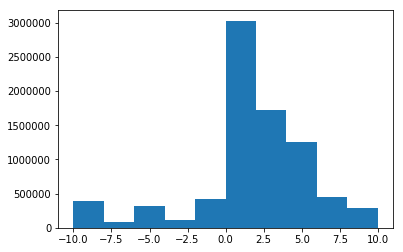

In [11]:
plt.hist(data['weight']);

# Extracting the networks

In [12]:
start_time = time.time()

separate_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=False, sum_multiple_edge=True)
accumulative_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=True, sum_multiple_edge=True)

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

It took : 6.3345235824584964 mins.


In [13]:
# Saves the networks.
with open('/local/home/student/omid55/sbt_data_saved/networks_avg.pkl', 'wb') as f:
    pk.dump({'separate_dgraphs': separate_dgraphs, 'accumulative_dgraphs': accumulative_dgraphs}, f)

In [417]:
# Picking only nodes which exist in all graphs.
start = 0
intersected_nodes = set(separate_dgraphs[start].nodes())
for separate_dgraph in separate_dgraphs[start+1:]:
    intersected_nodes = intersected_nodes.intersection(separate_dgraph.nodes())
print('#nodes kept:', len(intersected_nodes))
unified_sep_dgs = []
for separate_dgraph in separate_dgraphs:
    unified_sep_dgs.append(separate_dgraph.subgraph(intersected_nodes))
unified_sep_dgs = unified_sep_dgs[start:]

# Picking only nodes which exist in all graphs.
intersected_nodes2 = set(accumulative_dgraphs[start].nodes())
for accumulative_dgraph in accumulative_dgraphs[start+1:]:
    intersected_nodes2 = intersected_nodes2.intersection(accumulative_dgraph.nodes())
print('#nodes kept:', len(intersected_nodes2))
unified_acc_dgs = []
for accumulative_dgraph in accumulative_dgraphs:
    unified_acc_dgs.append(accumulative_dgraph.subgraph(intersected_nodes2))
unified_acc_dgs = unified_acc_dgs[start:]

#nodes kept: 134
#nodes kept: 144


In [418]:
len(unified_sep_dgs)

103

In [ ]:
# Saves the networks.
with open('/local/home/student/omid55/sbt_data_saved/unified_networks_avg_seasons.pkl', 'wb') as f:
    pk.dump({'separate_dgraphs': unified_sep_dgs, 'accumulative_dgraphs': unified_acc_dgs}, f)

# Plotting

In [ ]:
from pyvis.network import Network

In [ ]:
sns.set(rc={'figure.figsize':(8, 8)})
G = separate_dgraphs[0]

colors = []
for edge in G.edges():
    weight = G.get_edge_data(edge[0], edge[1])['weight']
    if weight == 0:
        colors.append('b')
    elif weight > 0:
        colors.append('g')
    else:
        colors.append('r')

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=30,
                       node_color='k',
                       cmap=plt.cm.Greys)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=colors)
plt.show()

In [ ]:
G = Network(directed=True, notebook=True)
G.from_nx(separate_dgraphs[0])
G.show_buttons(filter_=['physics'])
G.show("mygraph.html")

In [ ]:
# Just to create title names.
title_names = []
start_date = min(data['edge_date'])
end_date = max(data['edge_date'])
periods_num = int(np.floor((end_date - start_date).days / (weeks * 7)))
for period_index in range(periods_num):
    period_start = (
        start_date + period_index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    title_names.append('{} to {}'.format(period_start, period_end))

network_utils.plot_evolving_graphs(dgraphs=separate_dgraphs, titles=title_names)

# Computing the metrics for networks in periods

## Metrics for separate dynamic graphs

In [ ]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(separate_dgraphs[0]).keys())

evolving_metrics = collections.defaultdict(list)
for index, directed_graph in enumerate(separate_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(directed_graph)
    for key in sorted_keys:
        evolving_metrics[key].append(metrics[key])

In [ ]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(evolving_metrics['#pos edges'], 'g')
plt.plot(evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(evolving_metrics['#gcc pos edges'], 'g')
plt.plot(evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

# Goodness and fairness metric

In [ ]:
res = network_utils.compute_fairness_goodness(separate_dgraphs[0])

### Metrics for accumulative dynamic graphs

In [ ]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(accumulative_dgraphs[0]).keys())

accumulative_evolving_metrics = collections.defaultdict(list)
for index, accumulative_dgraph in enumerate(accumulative_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(accumulative_dgraph)
    for key in sorted_keys:
        accumulative_evolving_metrics[key].append(metrics[key])

In [ ]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(accumulative_evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(accumulative_evolving_metrics['#pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(accumulative_evolving_metrics['#gcc pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(accumulative_evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

## Separated graphs

In [ ]:
start_time = time.time()

edge_balances = []
for separate_dgraph in separate_dgraphs:
    edge_balances.append(
        network_utils.compute_edge_balance(separate_dgraph))

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

In [ ]:
m = 4
n = 4
sns.set(rc={'figure.figsize':(20, 20)})
for index, edge_balance in enumerate(edge_balances):
    num_unbalanced = []
    for value in edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

In [ ]:
transitions_balance = collections.defaultdict(list)
# transitions_div_unbalance = collections.defaultdict(list)
for edge_balance in edge_balances:
    for key, value in edge_balance.items():
        transitions_balance[key].append(value['#balanced']/value['#cycle3'])
#         transitions_div_unbalance[key].append(1 - value['#balanced'] / value['#cycle3'])


balanced_cycle3_ratio = []
for val in transitions_balance.values():
    if len(val) > 12:
        balanced_cycle3_ratio.append(val)

sns.set(rc={'figure.figsize':(8, 8)})
balanced_cycle3_ratio = np.array(balanced_cycle3_ratio)
n, m =balanced_cycle3_ratio.shape
plt.errorbar(x=np.arange(0, m),
             y=np.mean(balanced_cycle3_ratio, axis=0),
             yerr=np.std(balanced_cycle3_ratio, axis=0)/np.sqrt(n));

## Accumulative graphs

In [ ]:
accumulative_edge_balances = []
for accumulative_dgraph in accumulative_dgraphs:
    accumulative_edge_balances.append(
        network_utils.compute_edge_balance(accumulative_dgraph))

In [ ]:
m = 4
n = 4
sns.set(rc={'figure.figsize':(20, 20)})
for index, accumulative_edge_balance in enumerate(accumulative_edge_balances):
    num_unbalanced = []
    for value in accumulative_edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

In [ ]:
acc_transitions_balance = collections.defaultdict(list)
for accumulative_edge_balance in accumulative_edge_balances:
    for key, value in accumulative_edge_balance.items():
        acc_transitions_balance[key].append(value['#balanced'] / value['#cycle3'])

acc_balanced_cycle3_ratio = []
for val in acc_transitions_balance.values():
    if len(val) > 12:
        acc_balanced_cycle3_ratio.append(val)

sns.set(rc={'figure.figsize':(8, 8)})
acc_balanced_cycle3_ratio = np.array(acc_balanced_cycle3_ratio)
n, m = acc_balanced_cycle3_ratio.shape
plt.errorbar(x=np.arange(0, m),
             y=np.mean(acc_balanced_cycle3_ratio, axis=0),
             yerr=np.std(acc_balanced_cycle3_ratio, axis=0)/np.sqrt(n));

# Markov Chain of Sparse Triads

In [329]:
triad_map, triad_list = network_utils.generate_all_possible_sparse_triads()
unique_triad_num = len(triad_list)

## Separated graphs

In [330]:
start_time = time.time()

result = network_utils.compute_transition_matrix(
    dgraphs=unified_sep_dgs,
    unique_triad_num=unique_triad_num,
    triad_map=triad_map,
    verbose=True)

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')


# start_time = time.time()

# result = network_utils.compute_transition_matrix(
#     dgraphs=separate_dgraphs,
#     unique_triad_num=unique_triad_num,
#     triad_map=triad_map,
#     verbose=True)

# duration = time.time() - start_time
# print('It took :', duration/60, 'mins.')

.......................................................................................................

../../../src/utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(matrix.T / np.sum(matrix, axis=1)).T


It took : 227.95368640422822 mins.


In [332]:
# Saves the transitions.
with open('/local/home/student/omid55/sbt_data_saved/unified_transitions_avg_after2periods.pkl', 'wb') as f:
    pk.dump(result, f)

## Distribution of triads over time

In [353]:
num_of_unique_occuring_triads = []
ratio_over_time = []
for i in range(len(result['triads_types'][start:])):
    ratio = np.zeros(138)
    occuring_triads, counts = np.unique(np.array(list(result['triads_types'][i].values())), return_counts=True)
    ratio[occuring_triads] = counts / np.sum(counts)
    ratio_over_time.append(ratio)
    num_of_unique_occuring_triads.append(len(occuring_triads))
ratio_over_time = np.array(ratio_over_time)
ratio_over_time.shape

(101, 138)

In [266]:
len(np.where(ratio_over_time[0] > 0)[0]) - 10

88

(array([0.98550725, 0.98550725, 0.98550725, 0.99275362, 0.99275362,
        0.99275362, 0.99275362, 0.99275362, 0.99275362, 1.        ]),
 array([0.        , 0.06218514, 0.12437029, 0.18655543, 0.24874058,
        0.31092572, 0.37311086, 0.43529601, 0.49748115, 0.5596663 ,
        0.62185144]),
 <a list of 1 Patch objects>)

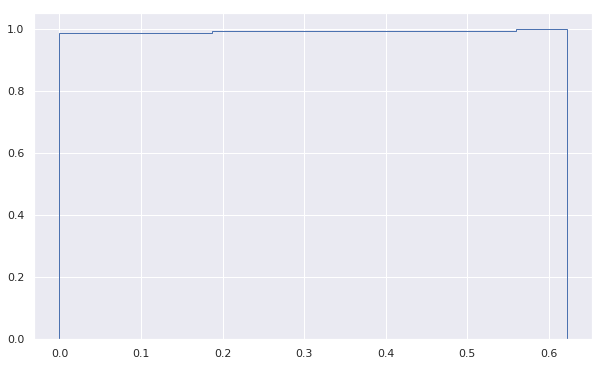

In [234]:
sns.set(rc={'figure.figsize': (10, 6)})
plt.hist(ratio_over_time[6], density=True, histtype='step', cumulative=True)

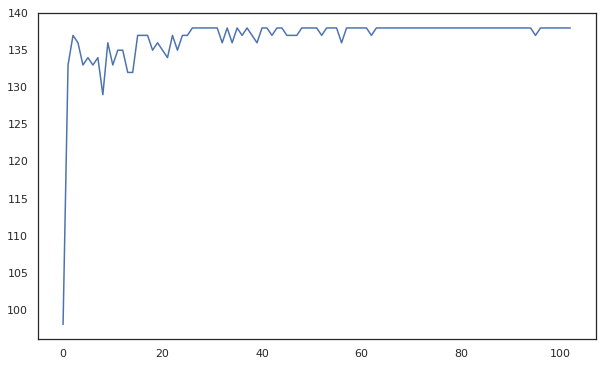

In [166]:
plt.plot(num_of_unique_occuring_triads);

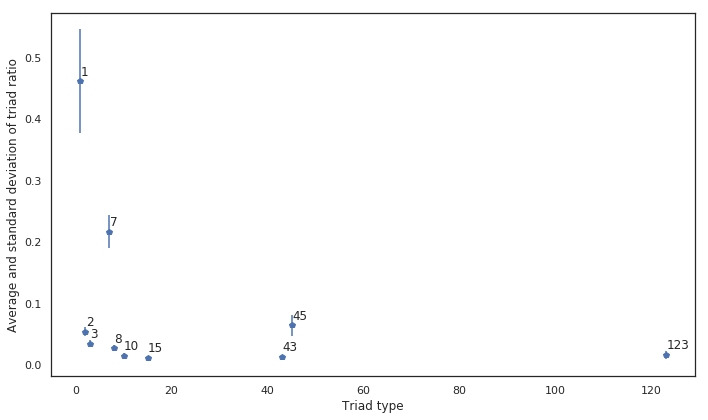

In [237]:
means = []
stds = [] 
for i in range(138):
    means.append(np.mean(ratio_over_time[:, i]))
    stds.append(np.std(ratio_over_time[:, i]))
means = np.array(means)
stds = np.array(stds)

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style("white")
x = np.arange(1, 139)
f, ax = plt.subplots()
indices = np.where(means > 0.01)[0]
ax.errorbar(x[indices], means[indices], stds[indices], linestyle='None', marker='p')

for index in indices:
    ax.annotate(str(x[index]), (x[index]+0.1, means[index]+0.01))
plt.xlabel('Triad type')
# plt.title('Distribution of triads over 23+ years ICEWS data.')
plt.ylabel('Average and standard deviation of triad ratio')

f.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('Triad_ratios_seasonly.pdf', bbox_inches='tight')

In [38]:
len([0, 1, 2, 6, 7, 9, 14, 42, 44, 122])

10

#### Plot only for these 10 triads

In [267]:
means = []
stds = [] 
for i in range(138):
    means.append(np.mean(ratio_over_time[:, i]))
    stds.append(np.std(ratio_over_time[:, i]))
means = np.array(means)
stds = np.array(stds)

In [241]:
indices = np.where(means > 0.01)[0]
len(indices)

10

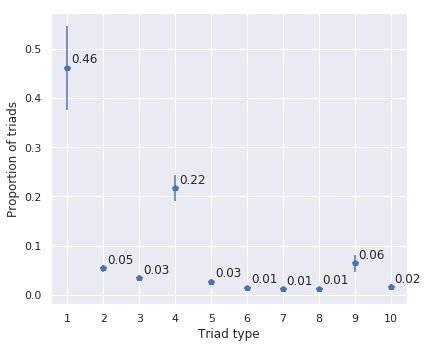

In [265]:
sns.set(rc={'figure.figsize': (6, 5)})
# sns.set_style("white")
x = np.arange(1, len(indices)+1)
f, ax = plt.subplots()
ax.set_xticks(x)
indices = np.where(means > 0.01)[0]
ax.errorbar(x, means[indices], stds[indices], linestyle='None', marker='p')

for i, index in enumerate(indices):
    ax.annotate('{:.2f}'.format(means[index]), (x[i]+0.1, means[index]+0.01))
plt.xlabel('Triad type')
# plt.title('Distribution of triads over 23+ years ICEWS data.')
plt.ylabel('Proportion of triads')

f.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Proportion_of_triad_seasonly.pdf', bbox_inches='tight')
plt.savefig('Proportion_of_triad_seasonly.png', bbox_inches='tight')

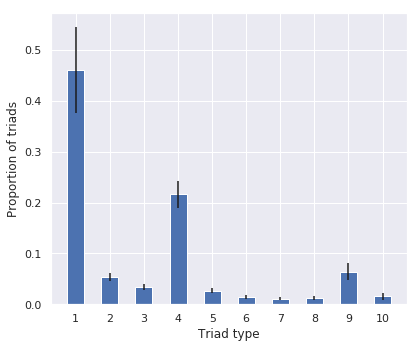

In [266]:
sns.set(rc={'figure.figsize': (6, 5)})
# sns.set_style("white")
x = np.arange(1, len(indices)+1)
f, ax = plt.subplots()
ax.set_xticks(x)
indices = np.where(means > 0.01)[0]
plt.bar(x, means[indices], width=0.5, yerr=stds[indices])

plt.xlabel('Triad type')
# plt.title('Distribution of triads over 23+ years ICEWS data.')
plt.ylabel('Proportion of triads')

f.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Proportion_of_triad_seasonly_bins.pdf', bbox_inches='tight')
plt.savefig('Proportion_of_triad_seasonly_bins.png', bbox_inches='tight')

In [174]:
indices = np.where(means > 0.02)[0]

print(indices)
print(np.sum(  means[indices]  ))

print('\nTriads:')
for index in indices:
    print(triad_list[index])
    print('\n')

[ 0  1  2  6  7 44]
0.8554352034530346

Triads:
[[0 0 0]
 [0 0 0]
 [0 0 0]]


[[0 0 0]
 [0 0 0]
 [0 1 0]]


[[ 0  0  0]
 [ 0  0  0]
 [ 0 -1  0]]


[[0 0 0]
 [0 0 1]
 [0 1 0]]


[[ 0  0  0]
 [ 0  0  1]
 [ 0 -1  0]]


[[0 0 1]
 [0 0 1]
 [1 1 0]]




In [171]:
indices

(array([ 0,  1,  2,  6,  7, 44]),)

In [169]:
print(np.where(means > 0.01))
print(np.sum(  means[np.where(means > 0.01)]  ))

(array([  0,   1,   2,   6,   7,   9,  14,  42,  44, 122]),)
0.909382678350181


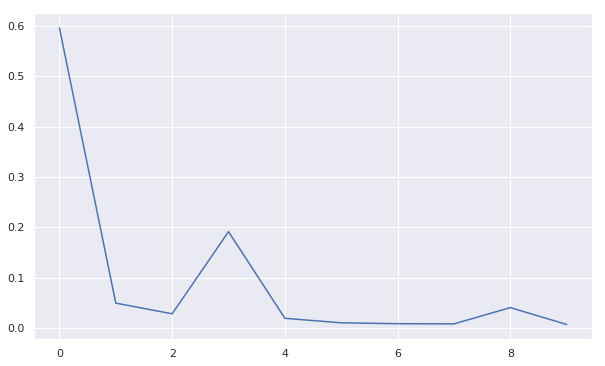

In [295]:
plt.plot(ratio_over_time[10, [core_triads_ids]][0])

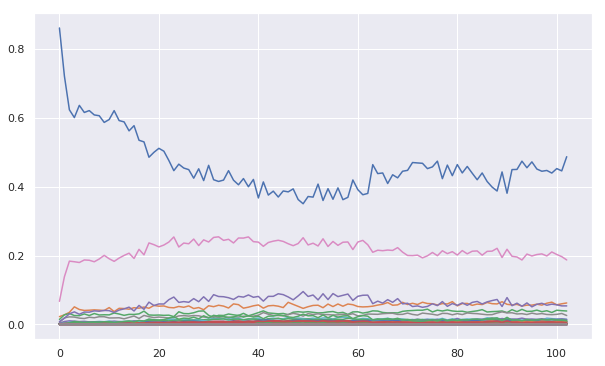

In [268]:
for i in range(138):
    plt.plot(ratio_over_time[:, i])

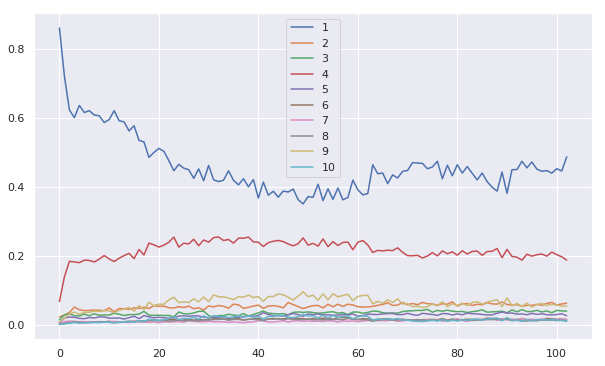

In [273]:
for core_triad_id in core_triads_ids:
    plt.plot(ratio_over_time[:, core_triad_id])
plt.legend(range(1, 11));

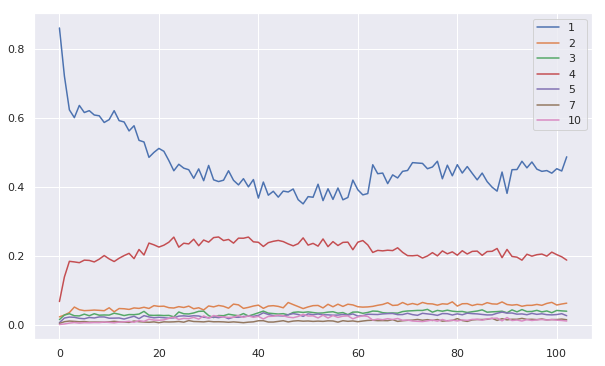

In [279]:
indices = np.array([1, 2, 3, 4, 5, 7, 10]) - 1
for core_triad_id in np.array(core_triads_ids)[indices]:
    plt.plot(ratio_over_time[:, core_triad_id])
plt.legend(indices + 1);

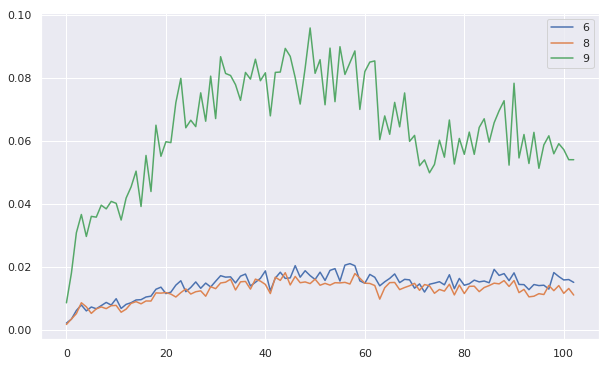

In [280]:
indices = np.array([6, 8, 9]) - 1
for core_triad_id in np.array(core_triads_ids)[indices]:
    plt.plot(ratio_over_time[:, core_triad_id])
plt.legend(indices + 1);

In [306]:
balanced_core_triad_indices = np.array(core_triads_ids)[np.array([1, 2, 3, 4, 5, 7, 10]) - 1]
unbalanced_core_triad_indices = np.array(core_triads_ids)[np.array([6, 8, 9]) - 1]

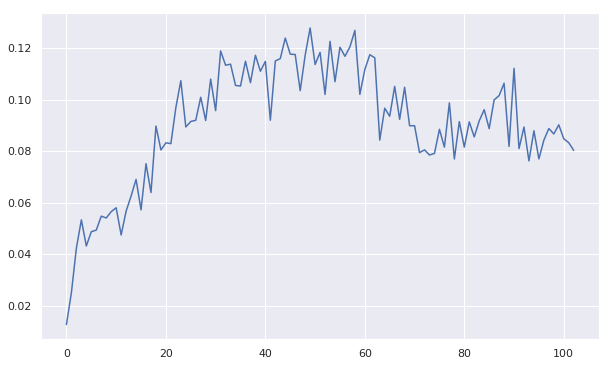

In [307]:
plt.plot([np.sum(ratio_over_time[i, unbalanced_core_triad_indices]) for i in range(103)])

In [261]:
growths = []
for i in range(138):
    growths.append(ratio_over_time[-1, i] - ratio_over_time[0, i])
growths = np.array(growths)

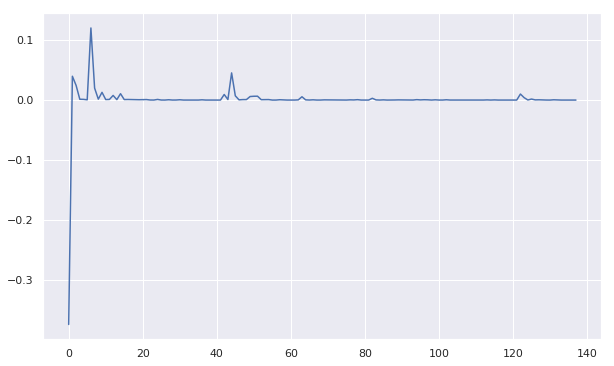

In [262]:
sns.set(rc={'figure.figsize': (10, 6)})
plt.plot(growths);

In [263]:
np.where(growths > 0.01)[0] + 1

array([  2,   3,   7,   8,  10,  15,  45, 123])

# First and last period

In [362]:
def print_country_edges(country_code):
    print(country_names[country_code])
    print('In: ', unified_sep_dgs[0].in_edges(country_code))
    print('Out: ', unified_sep_dgs[0].out_edges(country_code))

In [363]:
def get_only_positive_edges_digraph(dg):
    only_positive_edges_dg = dg.copy()
    for edge in dg.edges():
        if dg.get_edge_data(edge[0], edge[1])['weight'] <= 0:
            only_positive_edges_dg.remove_edge(edge[0], edge[1])
    return only_positive_edges_dg

In [364]:
def print_edge_weights_to_big_components(dg, node_list):
    countries = []
    for nodes in node_list:
        this_component_weights = 0
        if len(nodes) < 3:
            for node in list(nodes):
                print(country_names[node])
                countries.append(country_names[node])
                for edge in list(dg.out_edges(node)) + list(dg.in_edges(node)):
                    if edge[0] in nodes and edge[1] in nodes:
                        continue
                    this_component_weights += dg.get_edge_data(edge[0], edge[1])['weight']
            print('Sum of weights: ', this_component_weights, '\n')
    return countries

In [366]:
list(nx.strongly_connected_components(unified_sep_dgs[-1]))

[{0,
  2,
  3,
  6,
  10,
  11,
  13,
  14,
  15,
  17,
  18,
  20,
  21,
  23,
  26,
  28,
  29,
  30,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  42,
  43,
  44,
  45,
  48,
  50,
  52,
  53,
  54,
  55,
  57,
  58,
  59,
  60,
  61,
  63,
  64,
  65,
  66,
  68,
  69,
  70,
  73,
  74,
  75,
  79,
  81,
  82,
  83,
  85,
  87,
  90,
  92,
  93,
  94,
  95,
  97,
  98,
  99,
  100,
  102,
  103,
  104,
  105,
  106,
  108,
  109,
  110,
  111,
  113,
  114,
  115,
  117,
  118,
  119,
  120,
  121,
  122,
  124,
  125,
  127,
  128,
  131,
  132,
  134,
  135,
  138,
  141,
  143,
  145,
  146,
  148,
  149,
  150,
  151,
  153,
  154,
  157,
  158,
  159,
  160,
  163,
  165,
  166,
  167,
  168,
  170,
  171,
  172,
  173,
  174,
  176,
  177,
  179,
  181,
  182,
  183,
  194,
  195,
  196,
  198,
  199,
  201,
  202,
  203,
  204,
  205,
  207,
  209,
  210,
  211,
  212,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  226,
  227,
  228,
  229,
  233,
  23

### Proportion of positive, negative and null edges (dyad relationships)

In [419]:
start

0

In [421]:
134 * 133 / 2

8911.0

In [428]:
pos_ratios = []
neg_ratios = []
null_ratios = []

for unified_sep_dg in unified_sep_dgs[start:]:
    n = len(unified_sep_dg.nodes())
    all_possible_edge_cnt = n * (n-1)
    
    pos = 0
    neg = 0
#     nulls = 0
    for edge in unified_sep_dg.edges():
        w = unified_sep_dg.get_edge_data(edge[0], edge[1])['weight']
        if w > 0:
            pos += 1
        elif w < 0:
            neg += 1
#         else:
#             nulls += 1
    nulls = all_possible_edge_cnt - (pos + neg)
    pos_ratios.append(pos / (pos + neg + nulls))
    neg_ratios.append(neg / (pos + neg + nulls))
    null_ratios.append(nulls / (pos + neg + nulls))

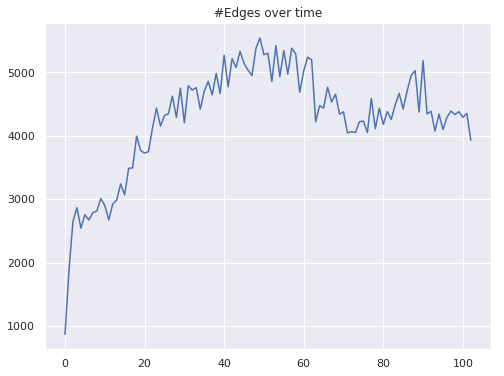

In [430]:
sns.set(rc={'figure.figsize': (8, 6)})
plt.plot([len(unified_sep_dg.edges()) for unified_sep_dg in unified_sep_dgs[start:]])
plt.title('#Edges over time');

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


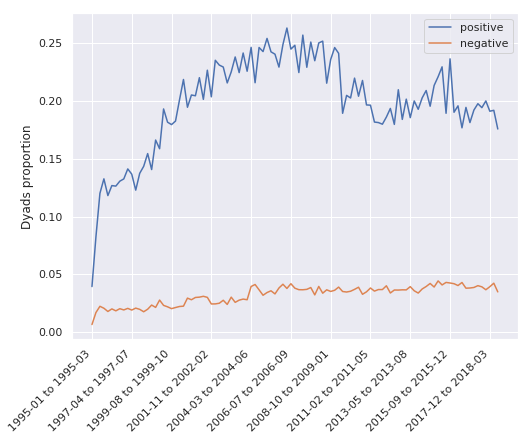

In [437]:
# FINAL FIGURE.
sns.set(rc={'figure.figsize': (8, 6)})
# sns.set_style("white")
plt.plot(pos_ratios)
plt.plot(neg_ratios)
plt.legend(['positive', 'negative'])
plt.ylabel('Dyads proportion');
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
periods_labels = range(0, number_of_periods, 10)
ax.set_xticks(list(periods_labels))
labels = ['{} to {}'.format(periods[i][0][:7], periods[i][1][:7]) for i in periods_labels]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
plt.savefig('Proportion_dyads.png', bbox_inches='tight')
plt.savefig('Proportion_dyads.pdf', bbox_inches='tight')

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


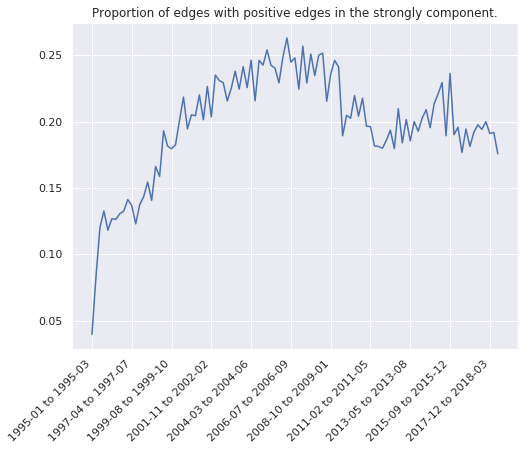

In [434]:
plt.plot(pos_ratios)
plt.title('Proportion of edges with positive edges in the strongly component.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
periods_labels = range(0, number_of_periods, 10)
ax.set_xticks(list(periods_labels))
labels = ['{} to {}'.format(periods[i][0][:7], periods[i][1][:7]) for i in periods_labels]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


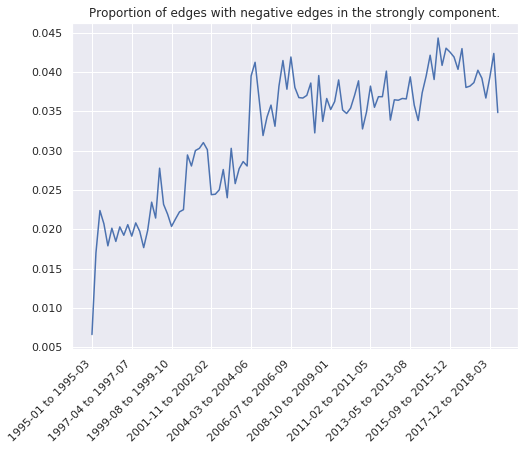

In [435]:
plt.plot(neg_ratios)
plt.title('Proportion of edges with negative edges in the strongly component.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
periods_labels = range(0, number_of_periods, 10)
ax.set_xticks(list(periods_labels))
labels = ['{} to {}'.format(periods[i][0][:7], periods[i][1][:7]) for i in periods_labels]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

In [43]:
[len(nodes) for nodes in list(nx.strongly_connected_components(unified_sep_dgs[0]))]

[1, 1, 1, 1, 1, 1, 1, 1, 120, 1, 1, 1, 2, 1]

In [121]:
[len(nodes) for nodes in list(nx.strongly_connected_components(get_only_positive_edges_digraph(unified_sep_dgs[0])))]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 111, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]

In [123]:
[len(nodes) for nodes in list(nx.strongly_connected_components(get_only_positive_edges_digraph(unified_sep_dgs[-1])))]

[134]

In [142]:
print_edge_weights_to_big_components(
    unified_sep_dgs[0],
    list(nx.strongly_connected_components(unified_sep_dgs[0])))

Afghanistan
Sum of weights:  -7.0 

Timor-Leste
Sum of weights:  -10.0 

Guinea
Sum of weights:  7.0 

Rwanda
Sum of weights:  1.5 

Sudan
Sum of weights:  -2.0 

Zimbabwe
Sum of weights:  5.2 

Bolivia
Sum of weights:  7.4 

Paraguay
Sum of weights:  7.4 

Congo
Sum of weights:  0.0 

Grenada
Sum of weights:  -2.0 

Guyana
Sum of weights:  6.0 

Malawi
Mozambique
Sum of weights:  0.0 

Nicaragua
Sum of weights:  -6.0 



In [152]:
countries = print_edge_weights_to_big_components(
    unified_sep_dgs[0],
    list(nx.strongly_connected_components(get_only_positive_edges_digraph(unified_sep_dgs[0]))))

Afghanistan
Sum of weights:  -7.0 

Angola
Sum of weights:  -0.30000000000000027 

Guinea
Sum of weights:  7.0 

Haiti
Sum of weights:  33.7 

Sierra Leone
Sum of weights:  16.3 

Zimbabwe
Sum of weights:  5.2 

Bolivia
Sum of weights:  7.4 

Paraguay
Sum of weights:  7.4 

Rwanda
Sum of weights:  1.5 

Armenia
Azerbaijan
Sum of weights:  -14.0 

Congo
Sum of weights:  0.0 

Grenada
Sum of weights:  -2.0 

Guatemala
Sum of weights:  6.4 

Guyana
Sum of weights:  6.0 

Kuwait
Sum of weights:  8.4 

Malawi
Mozambique
Sum of weights:  0.0 

Nicaragua
Sum of weights:  -6.0 

Nigeria
Sum of weights:  -7.4 

Panama
Sum of weights:  3.0 

Sudan
Sum of weights:  -2.0 

Timor-Leste
Sum of weights:  -10.0 



In [159]:
len(list(nx.strongly_connected_components(get_only_positive_edges_digraph(unified_sep_dgs[-1]))))

1

In [156]:
for s in countries:
    print('{}, '.format(s), end = '')

Afghanistan, Angola, Guinea, Haiti, Sierra Leone, Zimbabwe, Bolivia, Paraguay, Rwanda, Armenia, Azerbaijan, Congo, Grenada, Guatemala, Guyana, Kuwait, Malawi, Mozambique, Nicaragua, Nigeria, Panama, Sudan, Timor-Leste, 

In [348]:
def print_dg_stats(dg):
    print('#nodes: {}\n#edges: {}'.format(len(dg.nodes()), len(dg.edges())))

    n = len(dg.nodes())
    weights = []
    for edge in dg.edges():
        weights.append(dg.get_edge_data(edge[0], edge[1])['weight'])
    weights = np.array(weights)
    print('+: ', len(np.where(weights > 0)[0]) / (n*(n-1)))
    print('-: ', len(np.where(weights < 0)[0]) / (n*(n-1)))
    print('0: ', len(np.where(weights == 0)[0]) / (n*(n-1)))
    print('null: ', ((n*(n-1)) - len(weights)) / (n*(n-1)))

In [349]:
print_dg_stats(unified_sep_dgs[0])

#nodes: 134
#edges: 865
+:  0.039445628997867806
-:  0.00662103018740882
0:  0.0024688587139490518
null:  0.9514644821007743


In [350]:
print_dg_stats(unified_sep_dgs[-1])

#nodes: 134
#edges: 3931
+:  0.17568174166760184
-:  0.03484457412187184
0:  0.010043766131747279
null:  0.779429918078779


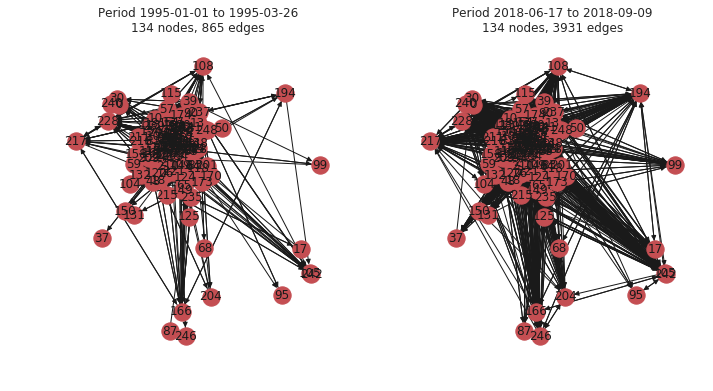

In [18]:
network_utils.plot_evolving_graphs(dgraphs=[unified_sep_dgs[0], unified_sep_dgs[-1]], titles=[
    'Period {} to {}'.format(periods[0][0], periods[0][1]),
    'Period {} to {}'.format(periods[-1][0], periods[-1][1])])

In [172]:
core = list(list(nx.strongly_connected_components(get_only_positive_edges_digraph(unified_sep_dgs[0])))[9])

In [175]:
import itertools

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


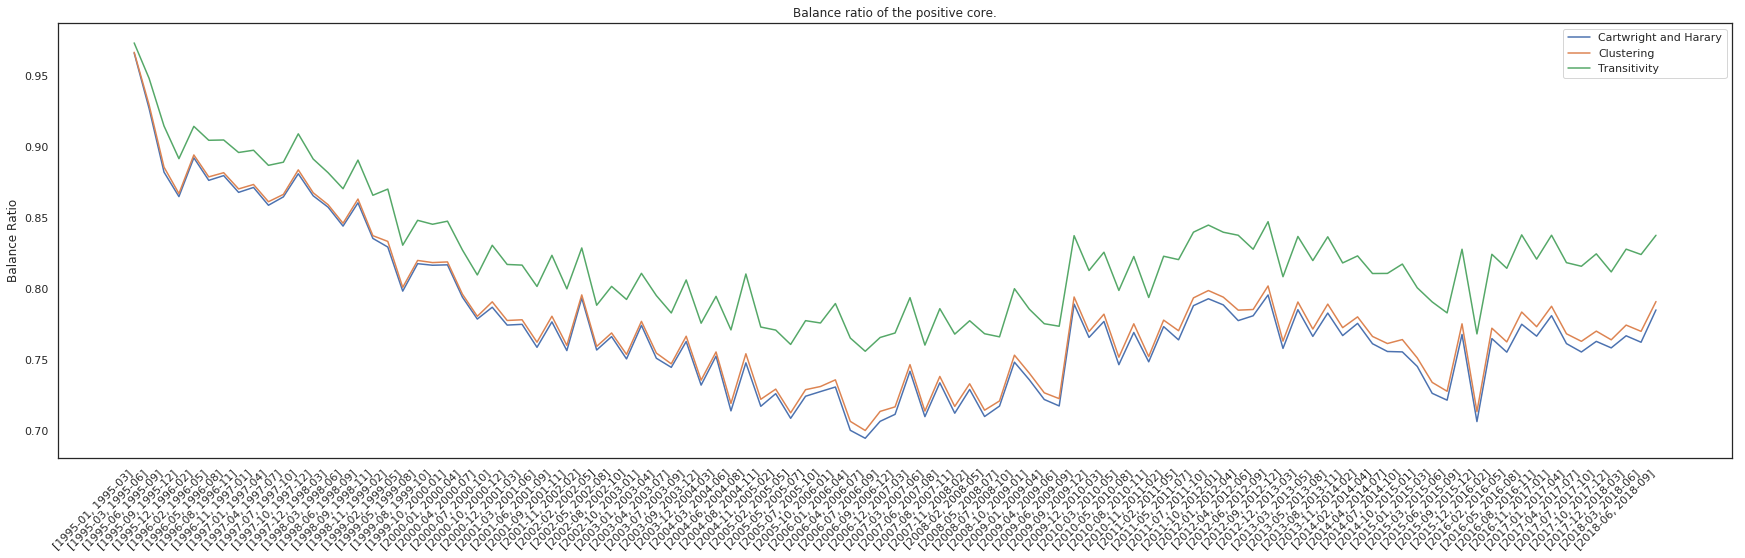

In [203]:
# sns.set(rc={'figure.figsize': (30, 8)})
# sns.set_style("white")
# ch_balance = []
# cluster_balance = []
# transitivity_balance = []
# core_triads = list(itertools.combinations(core, 3))
# for i in range(len(unified_sep_dgs)):
#     ch_balanced = 0
#     cl_balanced = 0
#     tr_balanced = 0
#     for triad in core_triads:
#         triad_index = result['triads_types'][i][str(tuple(sorted(triad)))]
#         if ch[triad_index]:
#             ch_balanced += 1
#         if cluster[triad_index]:
#             cl_balanced += 1
#         if transitives[triad_index]:
#             tr_balanced += 1
#     ch_balance.append(ch_balanced / len(core_triads))
#     cluster_balance.append(cl_balanced / len(core_triads))
#     transitivity_balance.append(tr_balanced / len(core_triads))
# plt.plot(ch_balance)
# plt.plot(cluster_balance)
# plt.plot(transitivity_balance)
# plt.legend(['Cartwright and Harary', 'Clustering', 'Transitivity'])
# plt.ylabel('Balance Ratio');
# plt.title('Balance ratio of the positive core.');
# # seting xticks
# ax = plt.axes()
# number_of_periods = len(periods)
# ax.set_xticks(list(range(number_of_periods)))
# labels = ['[{}, {}]'.format(periods[i][0][:7], periods[i][1][:7]) for i in range(number_of_periods)]
# ax.set_xticklabels(labels, rotation=45);
# for tick in ax.xaxis.get_majorticklabels():
#     tick.set_horizontalalignment("right");

In [213]:
ch_balance = []
cluster_balance = []
transitivity_balance = []
core_triads = list(itertools.combinations(core, 3))
for i in range(len(unified_sep_dgs)):
    ch_balanced = 0
    cl_balanced = 0
    tr_balanced = 0
    for triad in core_triads:
        triad_index = result['triads_types'][i][str(tuple(sorted(triad)))]
        if ch[triad_index]:
            ch_balanced += 1
        if cluster[triad_index]:
            cl_balanced += 1
        if transitives[triad_index]:
            tr_balanced += 1
    ch_balance.append(ch_balanced / len(core_triads))
    cluster_balance.append(cl_balanced / len(core_triads))
    transitivity_balance.append(tr_balanced / len(core_triads))

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


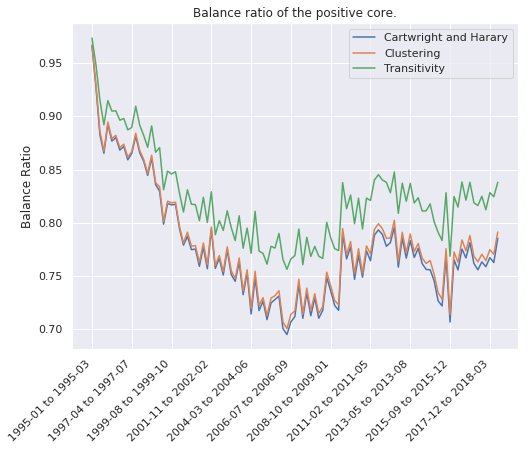

In [220]:
sns.set(rc={'figure.figsize': (8, 6)})
# sns.set_style("white")
plt.plot(ch_balance)
plt.plot(cluster_balance)
plt.plot(transitivity_balance)
plt.legend(['Cartwright and Harary', 'Clustering', 'Transitivity'])
plt.ylabel('Balance Ratio');
plt.title('Balance ratio of the positive core.');
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
periods_labels = range(0, number_of_periods, 10)
ax.set_xticks(list(periods_labels))
labels = ['{} to {}'.format(periods[i][0][:7], periods[i][1][:7]) for i in periods_labels]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
    
# plt.savefig('core_balanced_triads_ratio.png', bbox_inches='tight')

In [8]:
mean_transition_matrix = utils.make_matrix_row_stochastic(mean_transition_matrix)

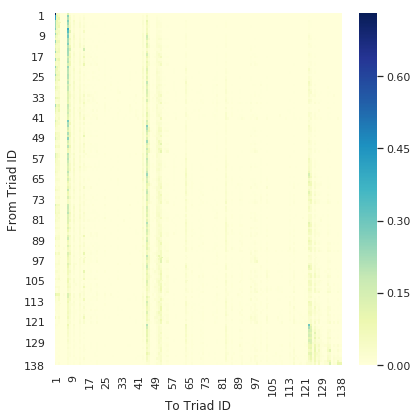

In [150]:
sns.set(rc={'figure.figsize': (6, 6)})
fig1, ax1 = plt.subplots()
sns.heatmap(mean_transition_matrix, cmap="YlGnBu") #, linewidths=.1);
triad_ids = list(range(1, 138+1-9, 8)) + [138]
ax1.set_xlabel('To Triad ID')
ax1.set_ylabel('From Triad ID')
ax1.set_xticks(triad_ids)
ax1.set_xticklabels(triad_ids)
ax1.set_yticks(triad_ids)
ax1.set_yticklabels(triad_ids)
fig1.tight_layout()
plt.savefig('mean_probability_stochastic_transition_matrix_seasonly.pdf', bbox_inches='tight')

In [55]:
np.max(mean_transition_matrix)

0.7315986822550241

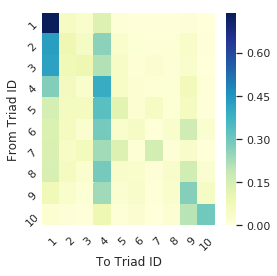

In [127]:
sns.set(rc={'figure.figsize': (4, 4)})
fig2, ax2 = plt.subplots()
core_triads_ids = [0, 1, 2, 6, 7, 9, 14, 42, 44, 122]
sns.heatmap(mean_transition_matrix[
    np.ix_(core_triads_ids, core_triads_ids)],
            cmap="YlGnBu", vmin=0, vmax=0.74)
ax2.set_xlabel('To Triad ID')
ax2.set_ylabel('From Triad ID')
labels = list(range(1, 11))
ax2.set_xticks(labels)
ax2.set_xticklabels(labels, rotation=45);
for tick in ax2.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
ax2.set_yticklabels(labels, rotation=45);
for tick in ax2.yaxis.get_majorticklabels():
    tick.set_horizontalalignment("center")
fig2.tight_layout()
plt.savefig('core_triads_mean_probability_stochastic_transition_matrix_seasonly.pdf', bbox_inches='tight');

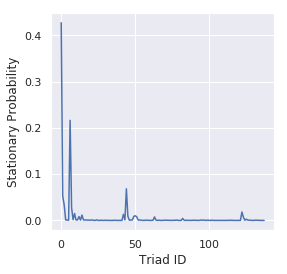

In [132]:
sns.set(rc={'figure.figsize': (4, 4)})
st_dist = network_utils.get_stationary_distribution(mean_transition_matrix)
plt.plot(st_dist)
plt.xlabel('Triad ID')
plt.ylabel('Stationary Probability');

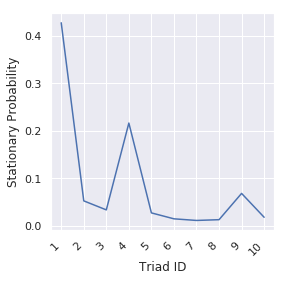

In [133]:
sns.set(rc={'figure.figsize': (4, 4)})
fig3, ax3 = plt.subplots()
plt.plot(range(1, 11), st_dist[core_triads_ids])
plt.xlabel('Triad ID')
plt.ylabel('Stationary Probability');
labels = list(range(1, 11))
ax3.set_xticks(labels)
ax3.set_xticklabels(labels, rotation=45);
for tick in ax3.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right");

In [135]:
st_dist[core_triads_ids]

array([0.42693805, 0.05276424, 0.03384501, 0.2162678 , 0.0275258 ,
       0.01505905, 0.01164468, 0.01323414, 0.06844941, 0.01831204])

In [158]:
utils.save_it(mean_transition_matrix, 'mean_transition_seasonly.pk')

In [159]:
mean_transition_matrix_monthly = utils.load_it('mean_transition_monthly.pk')
mean_transition_matrix_biweekly = utils.load_it('mean_transition_biweekly.pk')
mean_transition_matrix_weekly = utils.load_it('mean_transition_weekly.pk')

In [160]:
mean_transition_matrix_seasonly = mean_transition_matrix

In [161]:
pearsonr(mean_transition_matrix_monthly.flatten(), mean_transition_matrix.flatten())

(0.9794413385339699, 0.0)

In [162]:
pearsonr(mean_transition_matrix_biweekly.flatten(), mean_transition_matrix.flatten())

(0.913714257195629, 0.0)

In [163]:
pearsonr(mean_transition_matrix_weekly.flatten(), mean_transition_matrix.flatten())

(0.6308688496401306, 0.0)

In [165]:
pearsonr(
    mean_transition_matrix_seasonly[
        np.ix_(core_triads_ids, core_triads_ids)].flatten(),
    mean_transition_matrix_monthly[
        np.ix_(core_triads_ids, core_triads_ids)].flatten())

(0.9951379088826466, 1.8209500475787665e-100)

In [166]:
pearsonr(
    mean_transition_matrix_seasonly[
        np.ix_(core_triads_ids, core_triads_ids)].flatten(),
    mean_transition_matrix_biweekly[
        np.ix_(core_triads_ids, core_triads_ids)].flatten())

(0.9887046672391291, 1.3553443115320245e-82)

In [167]:
pearsonr(
    mean_transition_matrix_seasonly[
        np.ix_(core_triads_ids, core_triads_ids)].flatten(),
    mean_transition_matrix_weekly[
        np.ix_(core_triads_ids, core_triads_ids)].flatten())

(0.8644271710492994, 5.0144073616862255e-31)

In [136]:
biweekly = np.array(
    [0.29049558, 0.05981555, 0.04099356, 0.20392097, 0.03056414,
     0.02226224, 0.01707912, 0.01970311, 0.08940932, 0.03124171])
 = st_dist[core_triads_ids]
monthly = np.array(
    [0.38251308, 0.06027026, 0.04095717, 0.20701808, 0.0286176,
     0.01709647, 0.01392492, 0.01668288, 0.07194937, 0.01799641])
weekly = np.array(
    [0.11220552, 0.04033923, 0.02541566, 0.14676936, 0.0236561,
     0.02858389, 0.03103964, 0.02160708, 0.12289583, 0.08310463])

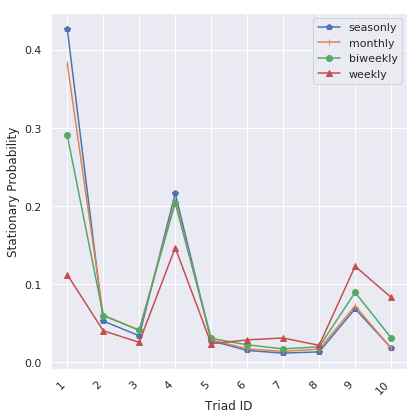

In [149]:
sns.set(rc={'figure.figsize': (6, 6)})
fig3, ax3 = plt.subplots()
plt.plot(range(1, 11), seasonly, marker='p')
plt.plot(range(1, 11), monthly, marker='|')
plt.plot(range(1, 11), biweekly, marker='o')
plt.plot(range(1, 11), weekly, marker='^')
plt.legend(['seasonly', 'monthly', 'biweekly', 'weekly'])
plt.xlabel('Triad ID')
plt.ylabel('Stationary Probability');
labels = list(range(1, 11))
ax3.set_xticks(labels)
ax3.set_xticklabels(labels, rotation=45);
for tick in ax3.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
fig3.tight_layout()
plt.savefig('core_triads_stationary_distribution.pdf', bbox_inches='tight');
plt.savefig('core_triads_stationary_distribution.png', bbox_inches='tight');

In [92]:
indices = np.argsort(np.sum(-mean_transition_matrix, axis=0))

In [24]:
indices

array([  6,  44,   0, 122,   7,  51, 123,  50,   1,   2,  45,  14,   9,
        63,  42,  49, 125,  12,  82, 127, 131, 132,  96,  54, 126,  94,
       115, 102,  53,  48,  97,  78,  20, 113, 124,  17,  99,  85,  90,
        47,  43,  16,  66,  52,  10,  13,  89, 136, 128,  24,  64,  71,
        95,  70,  19,  83,  46,  15,  18,  11,   4,   8,  30,  57,  77,
       134,  69,  76,  36,  58,  21,  39,   3,  27, 137,   5, 121,  62,
       120, 109,  88, 129, 130, 108, 118, 116, 107, 135, 103,  93, 106,
       100,  92, 117,  86,  74, 119, 105,  73,  40, 112,  67,  65, 114,
       104,  68,  35,  91, 101,  28,  31,  87,  80,  79,  33,  22, 111,
        84,  98,  37,  61,  72,  38,  29,  26,  34, 133,  59,  23,  75,
        60,  41,  81,  25,  32,  56,  55, 110])

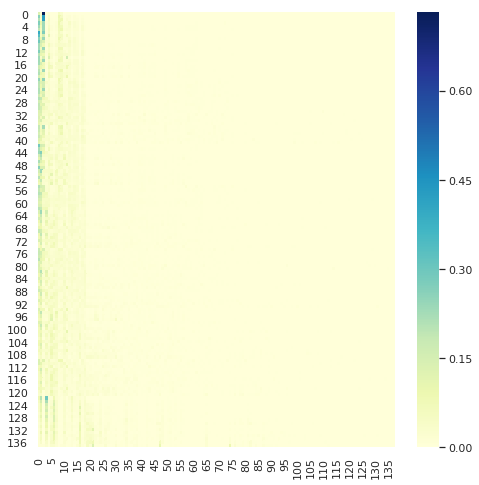

In [20]:
sns.heatmap(mean_transition_matrix[:, indices], cmap="YlGnBu")

#### Plots for the paper ends

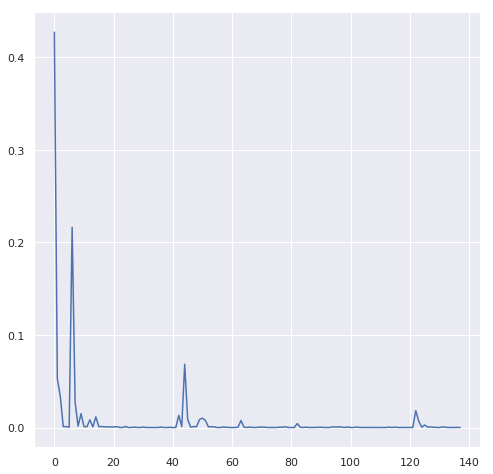

In [152]:
sns.set(rc={'figure.figsize': (8, 8)})
st_dist = network_utils.get_stationary_distribution(mean_transition_matrix)
plt.plot(st_dist);

In [28]:
for index in np.where(st_dist >= np.mean(st_dist))[0]:
    print(triad_list[index])
    print('\n')

[[0 0 0]
 [0 0 0]
 [0 0 0]]


[[0 0 0]
 [0 0 0]
 [0 1 0]]


[[ 0  0  0]
 [ 0  0  0]
 [ 0 -1  0]]


[[0 0 0]
 [0 0 1]
 [0 1 0]]


[[ 0  0  0]
 [ 0  0  1]
 [ 0 -1  0]]


[[0 0 0]
 [0 0 1]
 [1 1 0]]


[[ 0  0  0]
 [ 0  0  1]
 [-1  1  0]]


[[ 0  0  0]
 [ 0  0 -1]
 [ 0 -1  0]]


[[0 0 1]
 [0 0 1]
 [0 1 0]]


[[0 0 1]
 [0 0 1]
 [1 1 0]]


[[ 0  0  1]
 [ 0  0  1]
 [ 1 -1  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1  0  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1  1  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1 -1  0]]


[[0 0 1]
 [1 0 1]
 [1 1 0]]


[[0 1 1]
 [1 0 1]
 [1 1 0]]




In [162]:
for index in np.where(st_dist >= 0.04)[0]:
    print(triad_list[index])
    print('\n')

[[0 0 0]
 [0 0 0]
 [0 0 0]]


[[0 0 0]
 [0 0 0]
 [0 1 0]]


[[0 0 0]
 [0 0 1]
 [0 1 0]]


[[0 0 1]
 [0 0 1]
 [1 1 0]]




# Ratio of balanced triads over time

In [380]:
everyone_aware_of_others = True

ch = []
for triad in triad_list:
    ch.append(network_utils.is_sparsely_cartwright_harary_balanced(
        triad=triad, everyone_aware_of_others=everyone_aware_of_others))
ch = np.array(ch)

t = np.sum(ch)
print('{} C&H balance and {} non C&H balance.'.format(t, 138-t))



cluster = []
for triad in triad_list:
    cluster.append(network_utils.is_sparsely_clustering_balanced(
        triad=triad, everyone_aware_of_others=everyone_aware_of_others))
cluster = np.array(cluster)

t = np.sum(cluster)
print('{} clustering balance and {} non clustering balance.'.format(t, 138-t))



transitives = []
for triad in triad_list:
    transitives.append(network_utils.is_sparsely_transitive_balanced(
        triad=triad, everyone_aware_of_others=everyone_aware_of_others))
transitives = np.array(transitives)

t = np.sum(transitives)
print('{} transitive and {} nontransitive.'.format(t, 138-t))

24 C&H balance and 114 non C&H balance.
44 clustering balance and 94 non clustering balance.
93 transitive and 45 nontransitive.


### Balanced triads' ratio

In [383]:
ch_balance = []
cluster_balance = []
transitivity_balance = []
for period_triads in result['triads_types']:
    ch_balanced = 0.0
    cl_balanced = 0.0
    tr_balanced = 0.0
    for triad_index in period_triads.values():
        if ch[triad_index]:
            ch_balanced += 1.0
        if cluster[triad_index]:
            cl_balanced += 1.0
        if transitives[triad_index]:
            tr_balanced += 1.0
    ch_balance.append(ch_balanced / len(period_triads))
    cluster_balance.append(cl_balanced / len(period_triads))
    transitivity_balance.append(tr_balanced / len(period_triads))

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


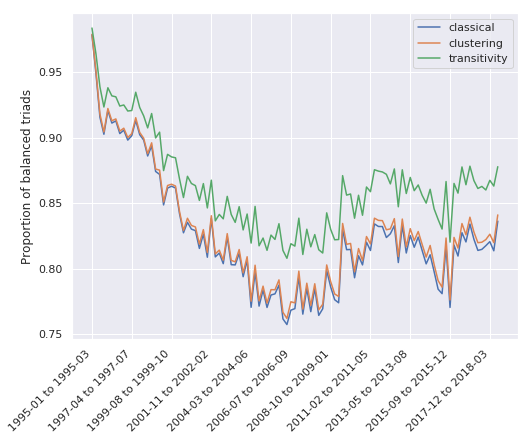

In [225]:
# FINAL FIGURE.
sns.set(rc={'figure.figsize': (8, 6)})
# sns.set_style("white")
plt.plot(ch_balance)
plt.plot(cluster_balance)
plt.plot(transitivity_balance)
plt.legend(['classical', 'clustering', 'transitivity'])
plt.ylabel('Proportion of balanced triads');
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
periods_labels = range(0, number_of_periods, 10)
ax.set_xticks(list(periods_labels))
labels = ['{} to {}'.format(periods[i][0][:7], periods[i][1][:7]) for i in periods_labels]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
    
plt.savefig('Proportion_balanced_triads.png', bbox_inches='tight')
plt.savefig('Proportion_balanced_triads.pdf', bbox_inches='tight')

In [ ]:
terzi_sprase_balance_ratios = [
    network_utils.terzi_sprase_balance_ratio(unified_sep_dg, undirected=False)
    for unified_sep_dg in unified_sep_dgs]

kunegis_sprase_balance_ratios = [
    network_utils.kunegis_sprase_balance_ratio(unified_sep_dg, undirected=False)
    for unified_sep_dg in unified_sep_dgs]

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


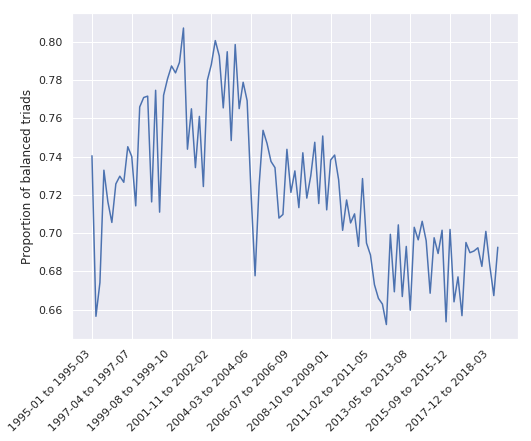

In [184]:
sns.set(rc={'figure.figsize': (8, 6)})
# sns.set_style("white")
plt.plot(terzi_sprase_balance_ratios)
plt.ylabel('Proportion of balanced triads');
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
periods_labels = range(0, number_of_periods, 10)
ax.set_xticks(list(periods_labels))
labels = ['{} to {}'.format(periods[i][0][:7], periods[i][1][:7]) for i in periods_labels]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


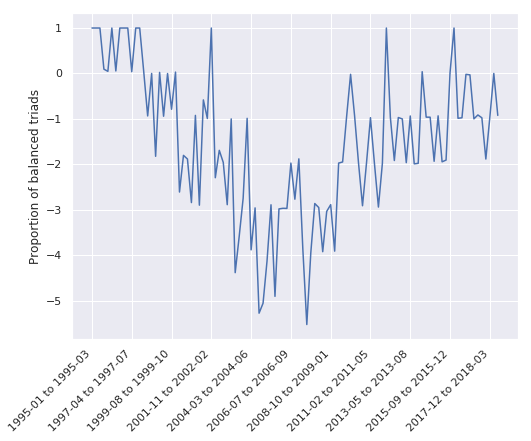

In [185]:
sns.set(rc={'figure.figsize': (8, 6)})
# sns.set_style("white")
plt.plot(kunegis_sprase_balance_ratios)
plt.ylabel('Proportion of balanced triads');
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
periods_labels = range(0, number_of_periods, 10)
ax.set_xticks(list(periods_labels))
labels = ['{} to {}'.format(periods[i][0][:7], periods[i][1][:7]) for i in periods_labels]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


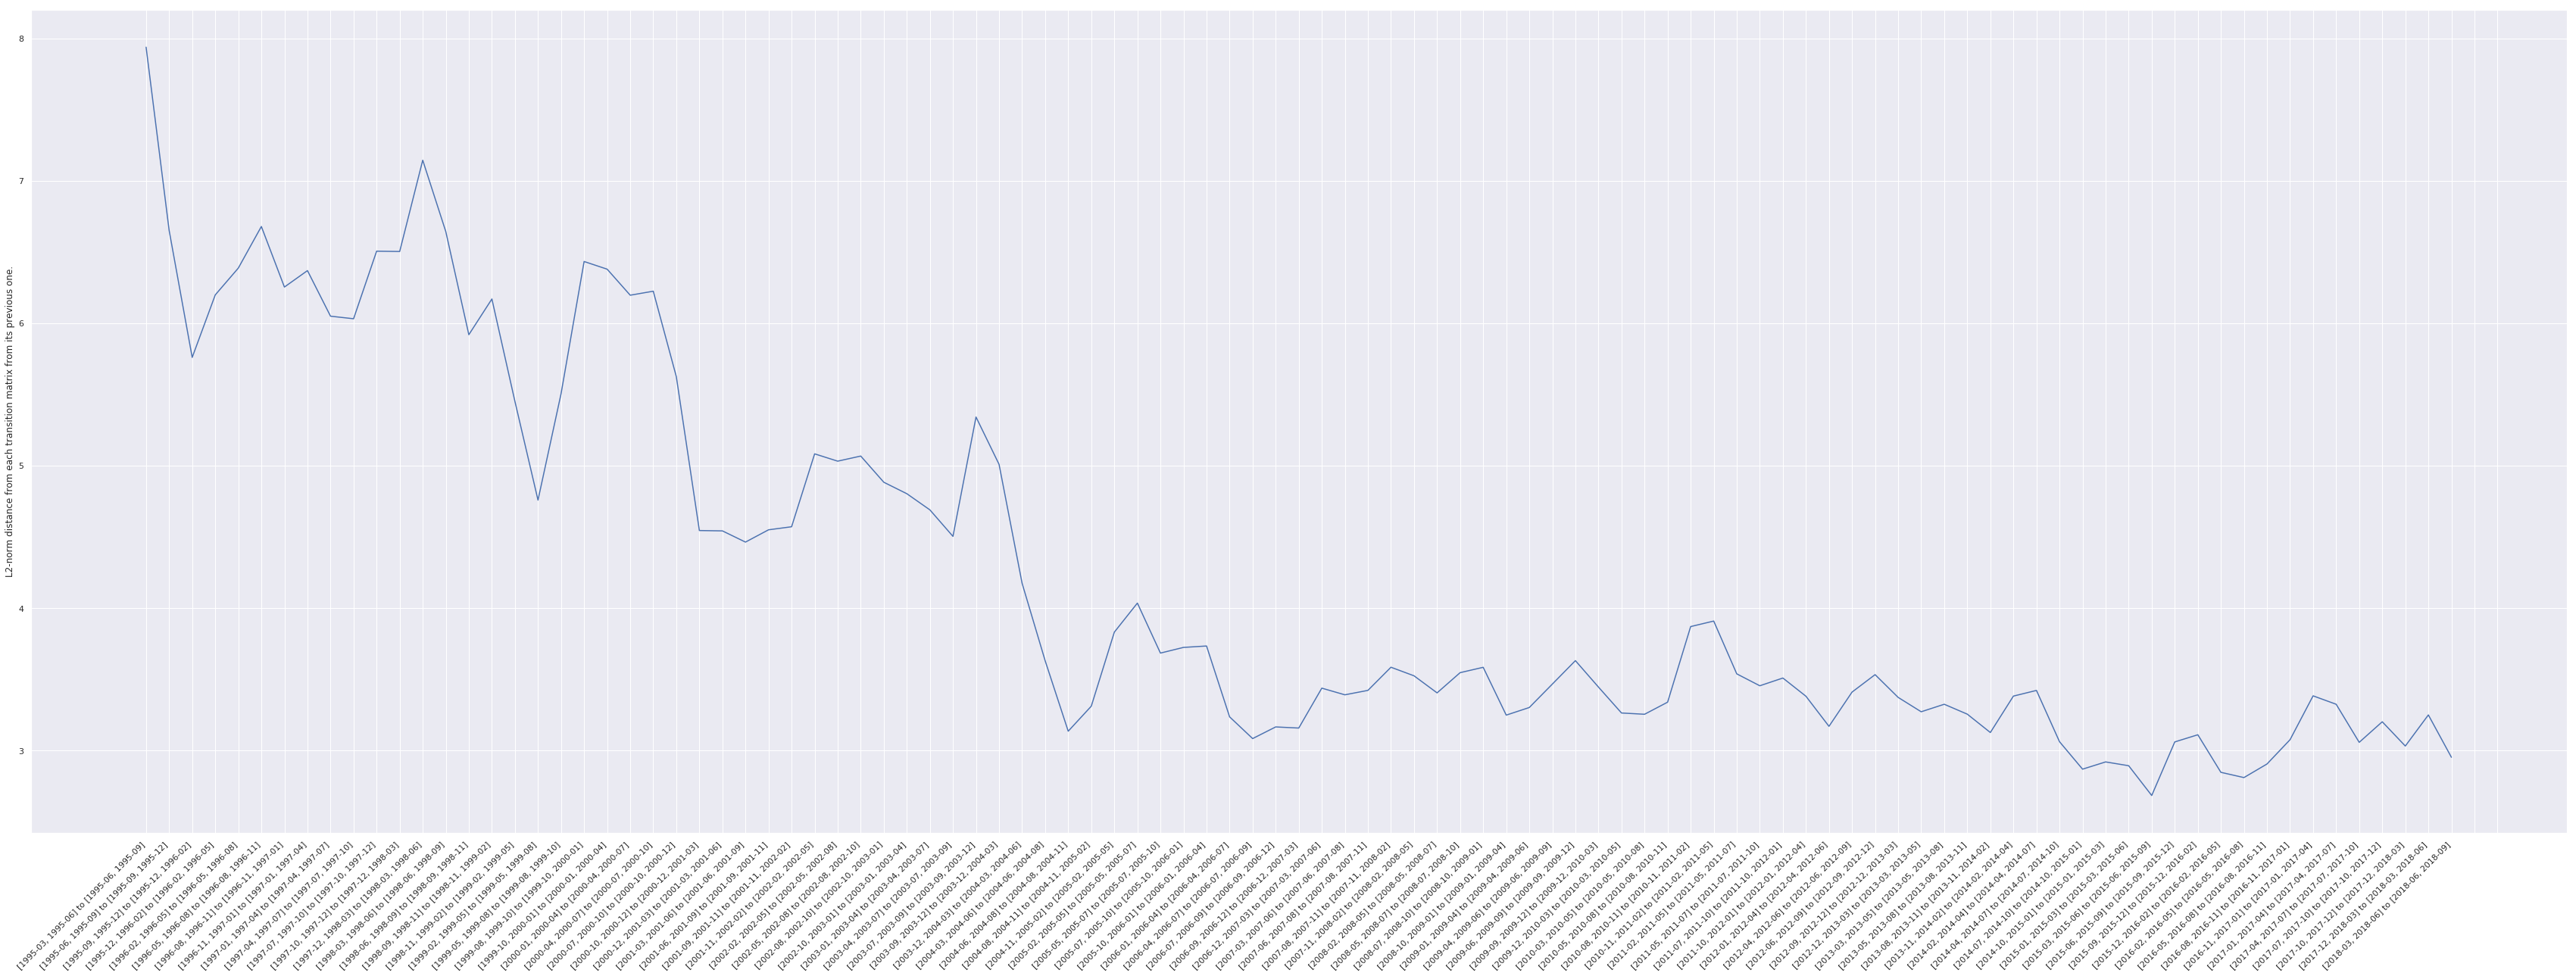

In [264]:
sns.set(rc={'figure.figsize': (60, 20)})
from_prev_l2norm_dists = []
n = len(result['transition_matrices'])
for i in range(1, n):
    current = result['transition_matrices'][i]
    prev = result['transition_matrices'][i-1]
    from_prev_l2norm_dists.append(np.linalg.norm(prev - current))
plt.plot(from_prev_l2norm_dists)
plt.ylabel('L2-norm distance from each transition matrix from its previous one.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}] to [{}, {}]'.format(periods[i][0][:7], periods[i][1][:7], periods[i+1][0][:7], periods[i+1][1][:7]) for i in range(1, number_of_periods - 1)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

/cs/student/omid55/.local/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


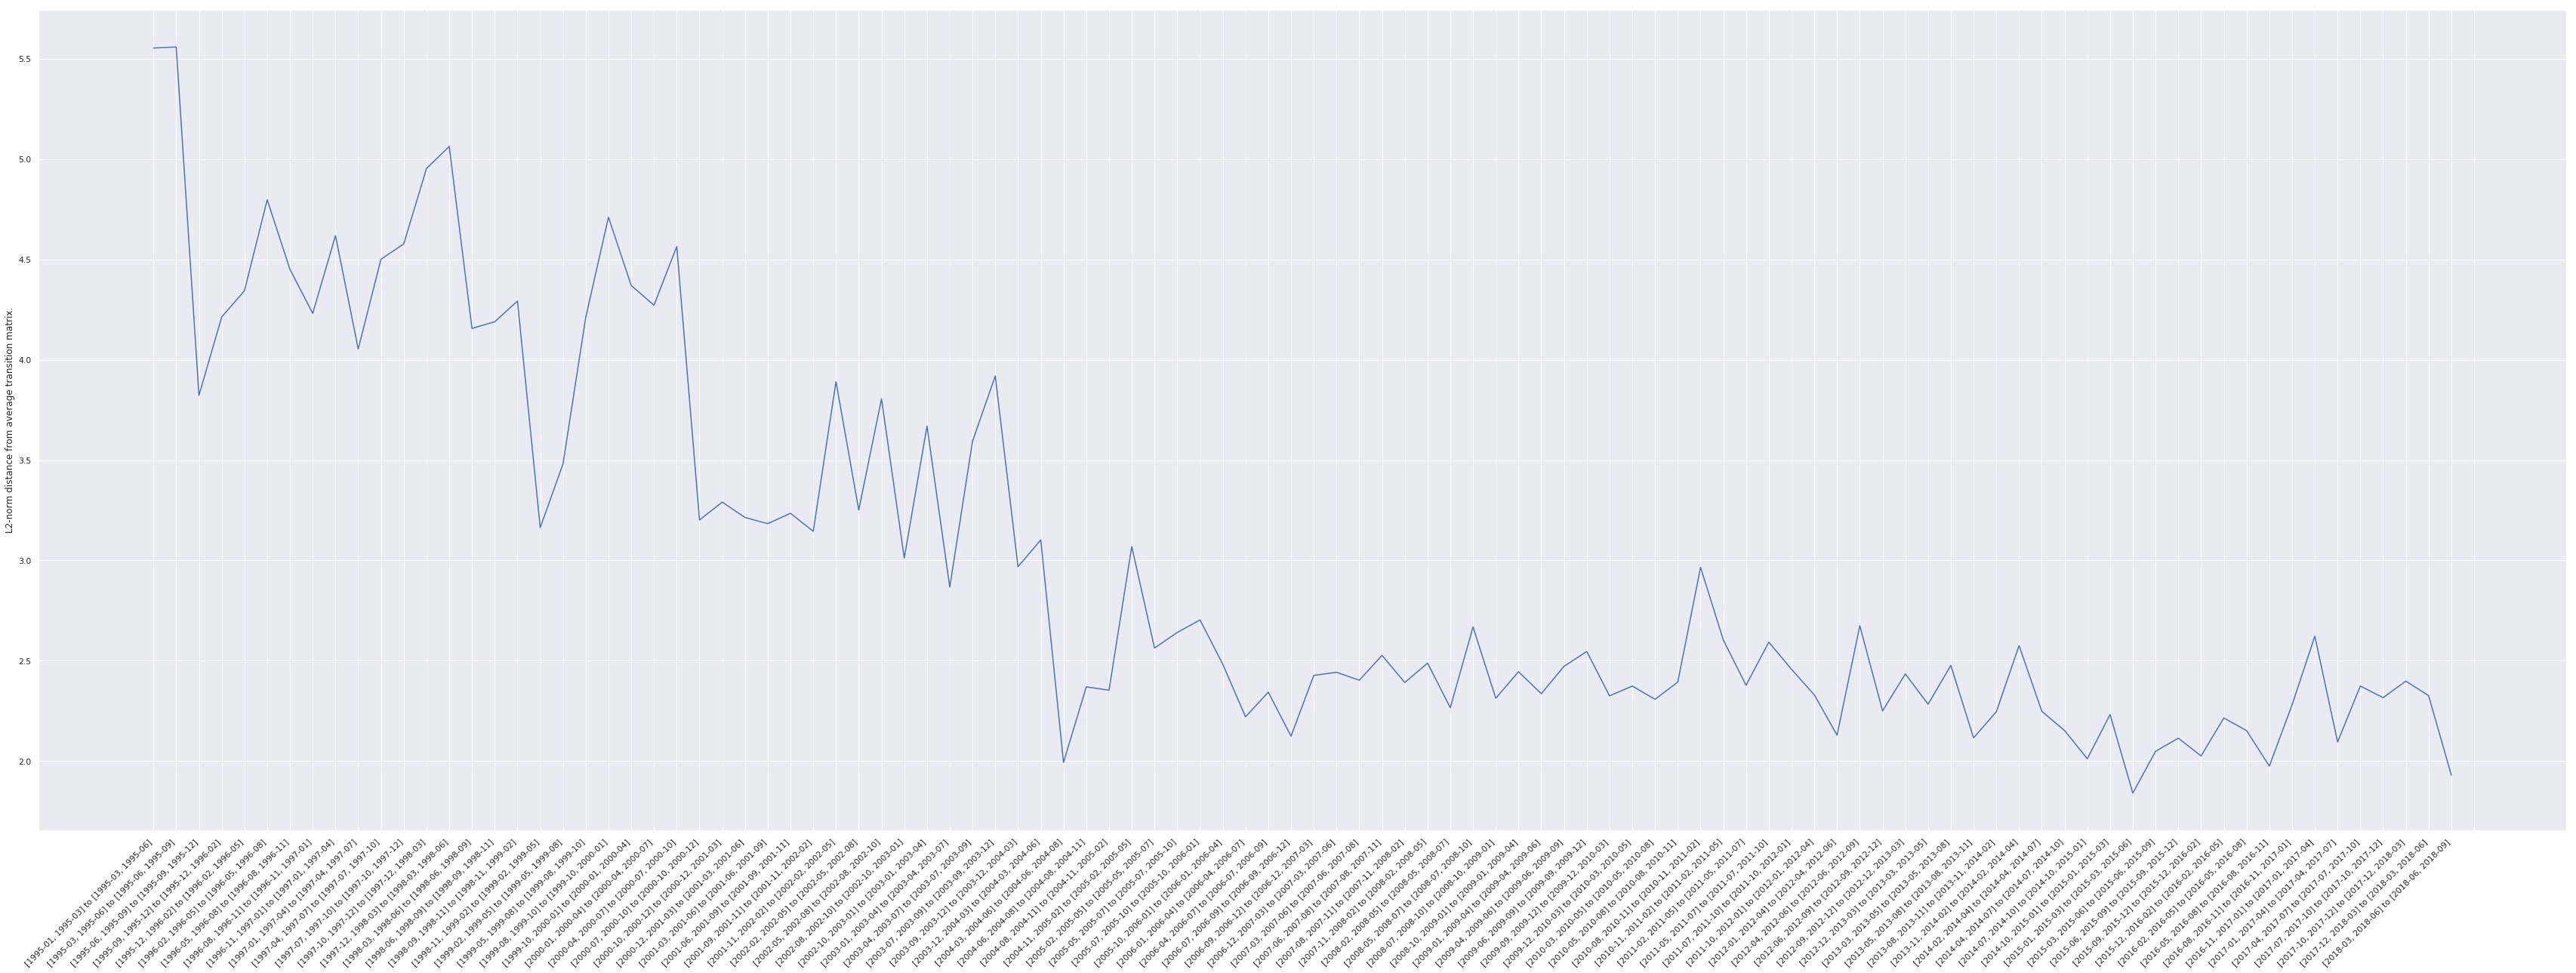

In [265]:
sns.set(rc={'figure.figsize': (60, 20)})
l2norm_dists = []
for matrix in result['transition_matrices']:
    l2norm_dists.append(np.linalg.norm(matrix - mean_transition_matrix))
plt.plot(l2norm_dists)
plt.ylabel('L2-norm distance from average transition matrix.')
# seting xticks
ax = plt.axes()
number_of_periods = len(periods)
ax.set_xticks(list(range(number_of_periods)))
labels = ['[{}, {}] to [{}, {}]'.format(periods[i][0][:7], periods[i][1][:7], periods[i+1][0][:7], periods[i+1][1][:7]) for i in range(number_of_periods-1)]
ax.set_xticklabels(labels, rotation=45);
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

## Accumulated graphs 

In [ ]:
start_time = time.time()

acc_result = network_utils.compute_transition_matrix(
    dgraphs=accumulative_dgraphs,
    unique_triad_num=unique_triad_num,
    triad_map=triad_map,
    verbose=True)

duration = time.time() - start_time
print('It took :', duration/60, 'mins.')

In [ ]:
# Saves the accumulative transitions.
with open('/local/home/student/omid55/sbt_data_saved/acc_transitions_avg.pkl', 'wb') as f:
    pk.dump(acc_result, f)

Nonzero percentage:  6.66 %


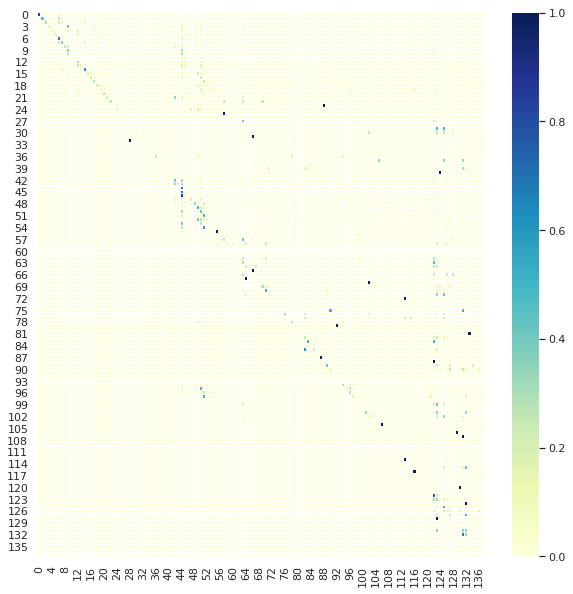

Nonzero percentage:  11.0 %


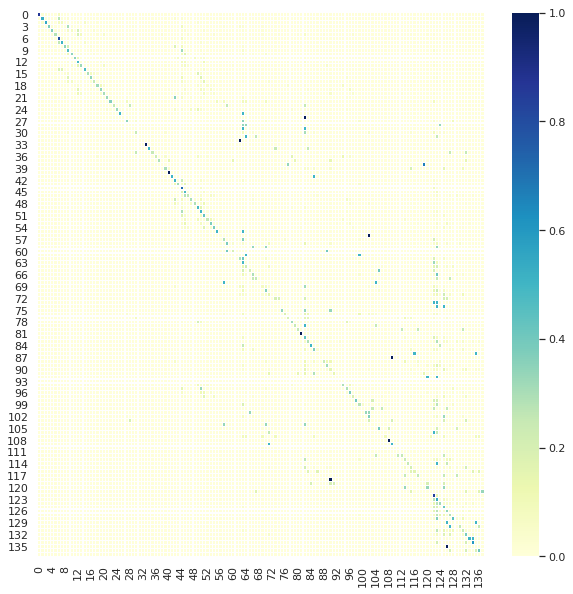

Nonzero percentage:  12.07 %


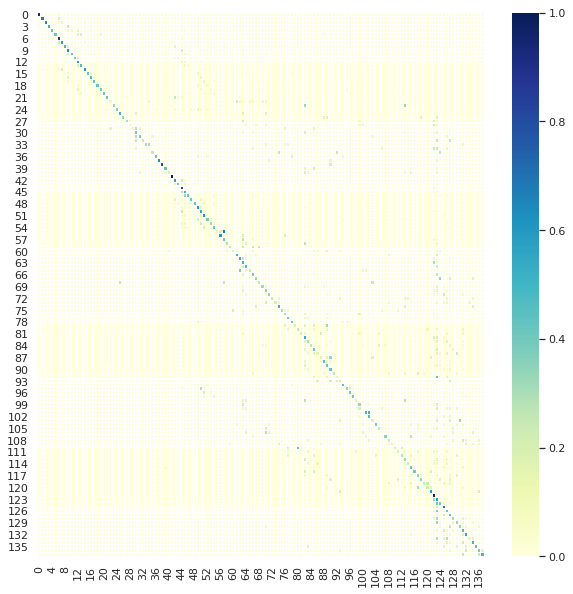

Nonzero percentage:  8.98 %


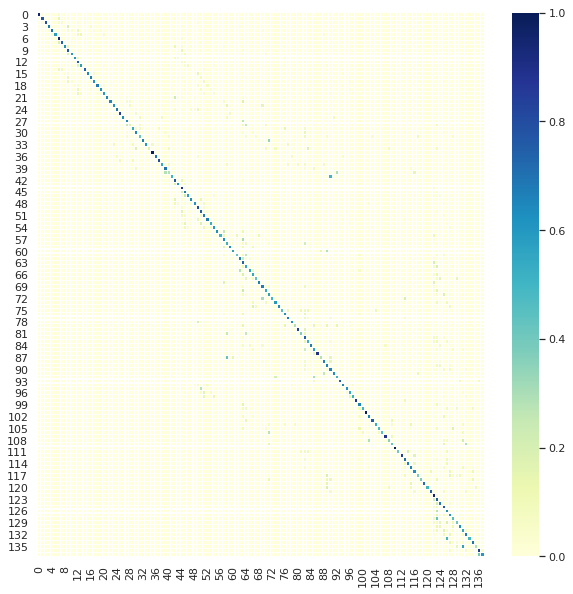

Nonzero percentage:  9.24 %


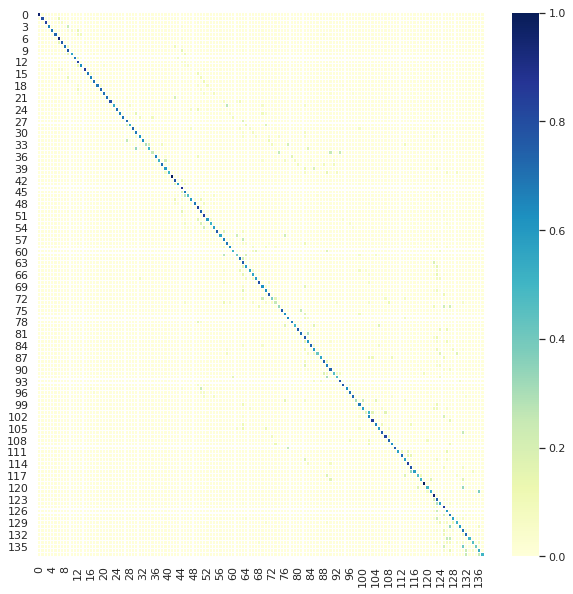

Nonzero percentage:  8.01 %


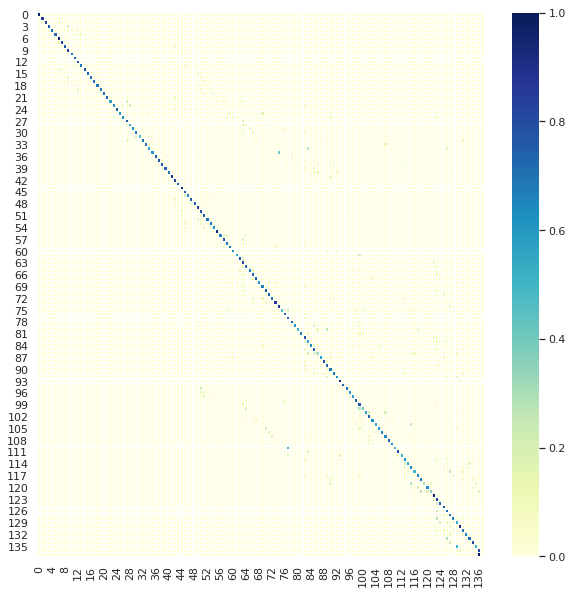

Nonzero percentage:  9.41 %


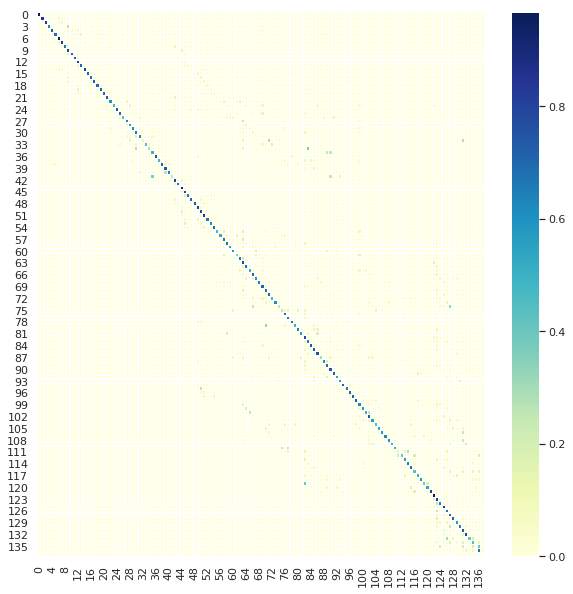

Nonzero percentage:  7.3 %


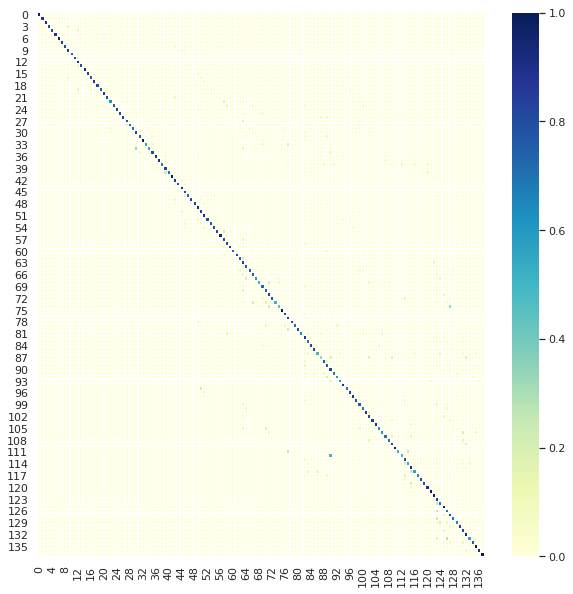

Nonzero percentage:  8.99 %


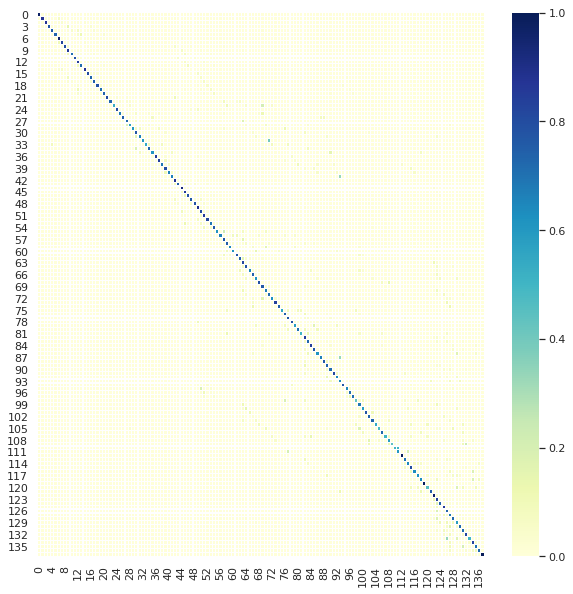

Nonzero percentage:  7.6 %


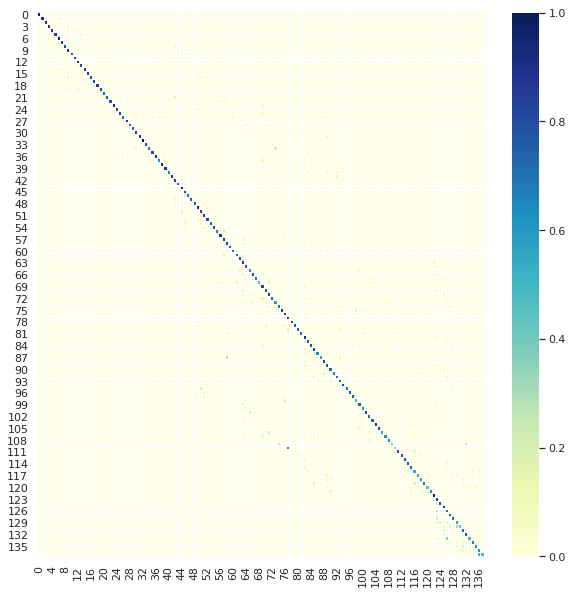

Nonzero percentage:  7.82 %


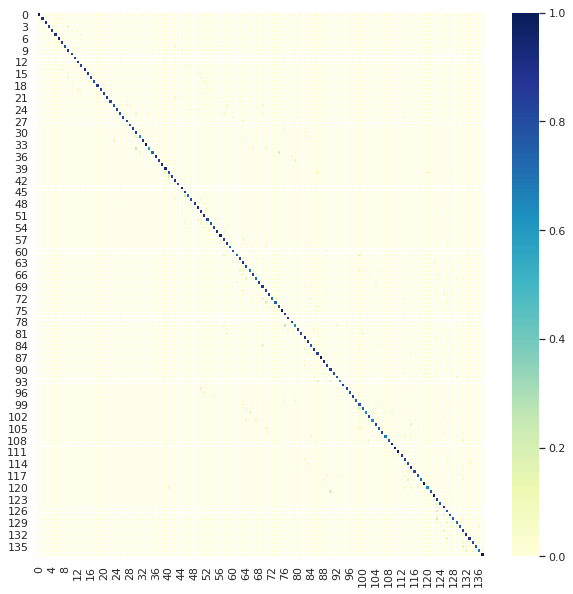

Nonzero percentage:  7.49 %


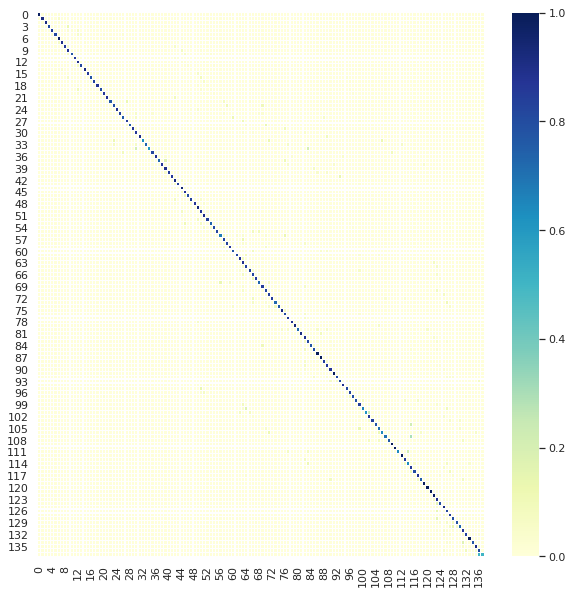

Nonzero percentage:  7.37 %


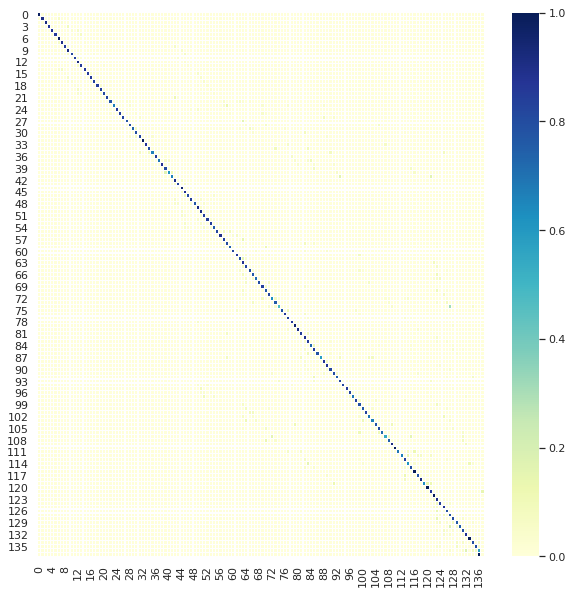

Nonzero percentage:  7.75 %


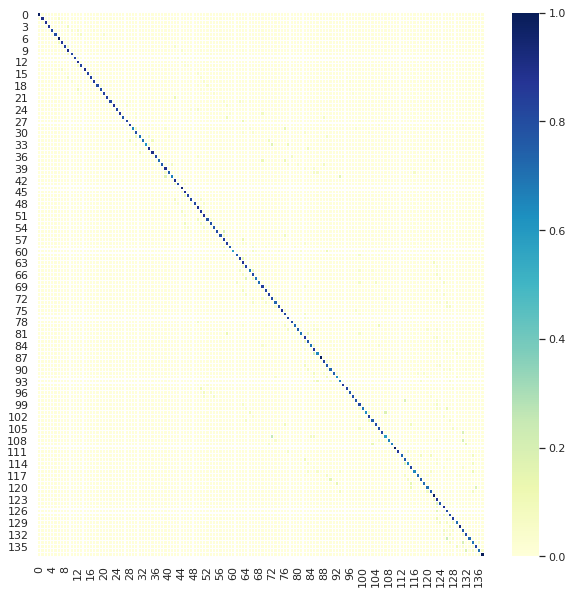

Nonzero percentage:  7.89 %


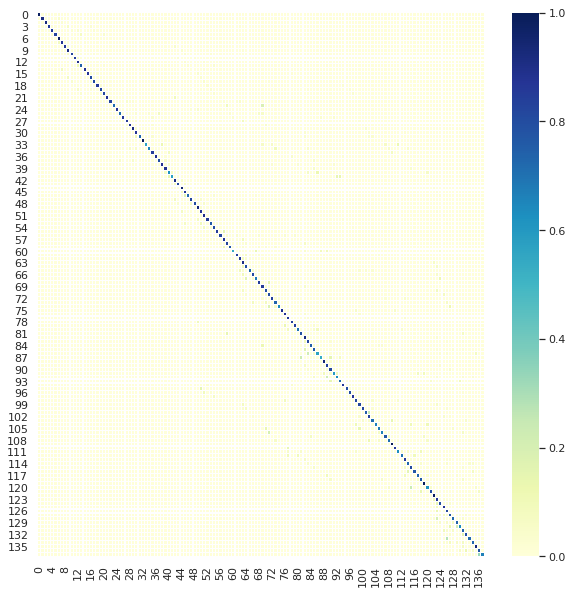

Nonzero percentage:  9.51 %


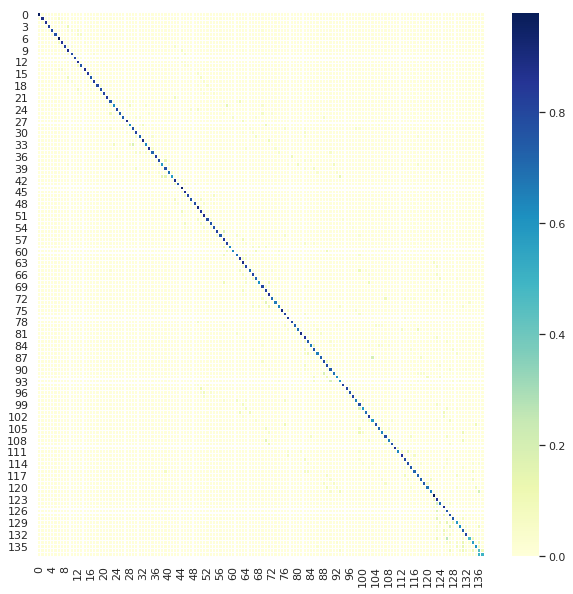

Nonzero percentage:  8.01 %


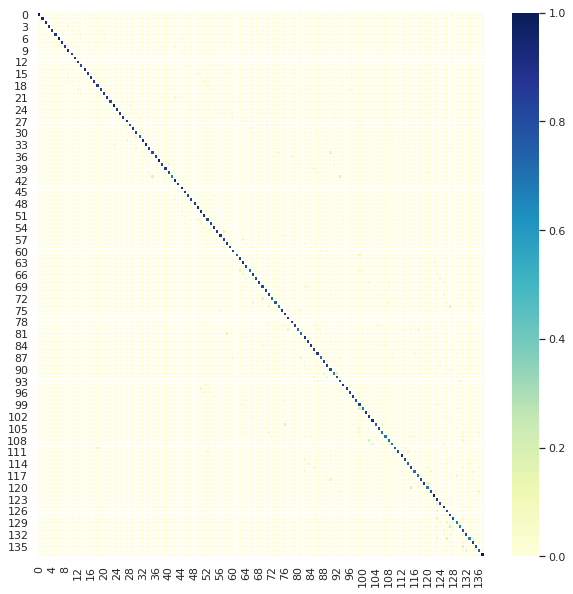

Nonzero percentage:  9.93 %


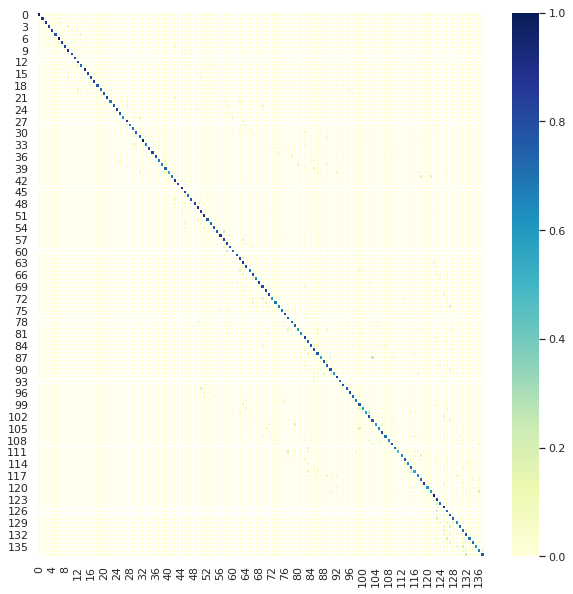

Nonzero percentage:  7.89 %


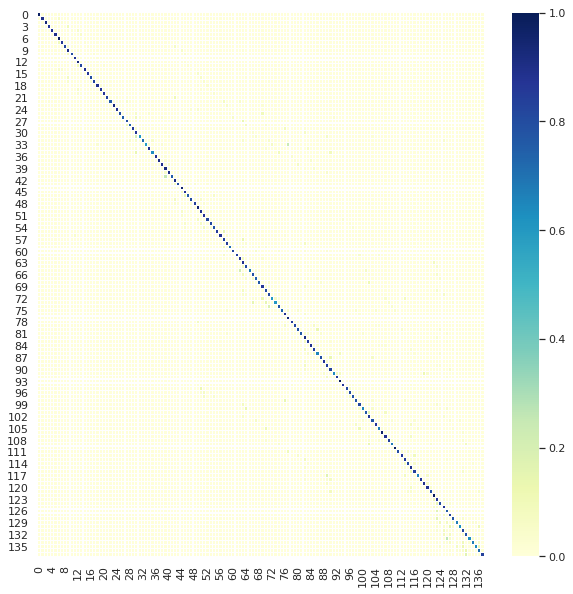

Nonzero percentage:  7.9 %


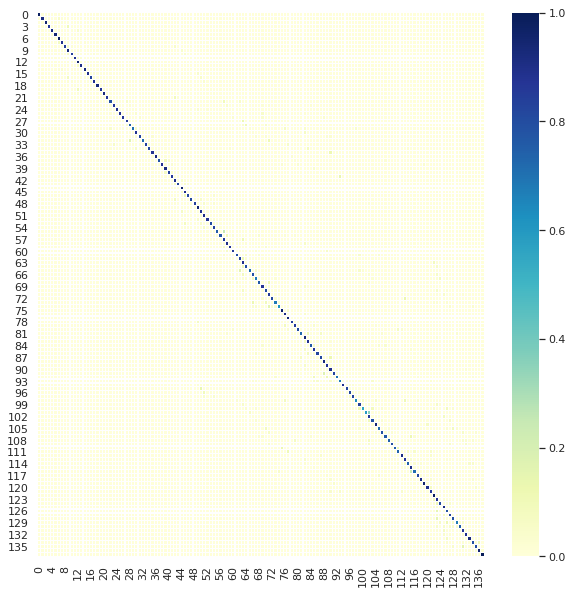

Nonzero percentage:  7.49 %


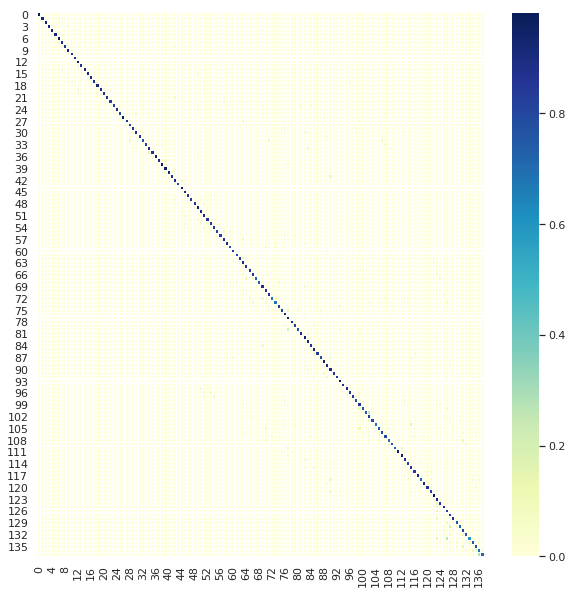

Nonzero percentage:  7.54 %


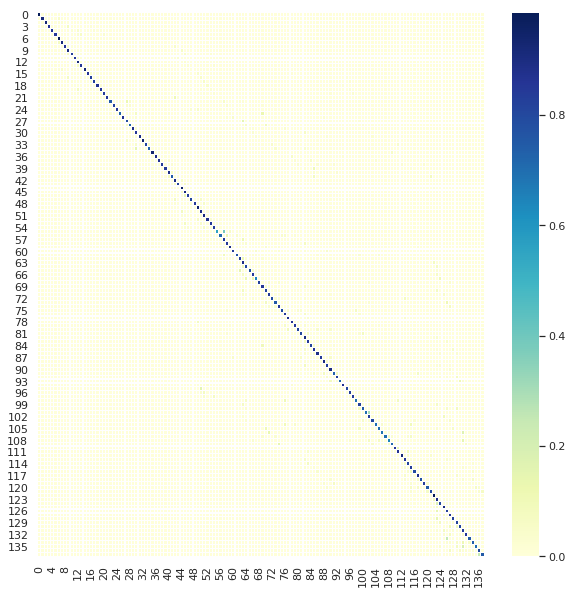

Nonzero percentage:  7.73 %


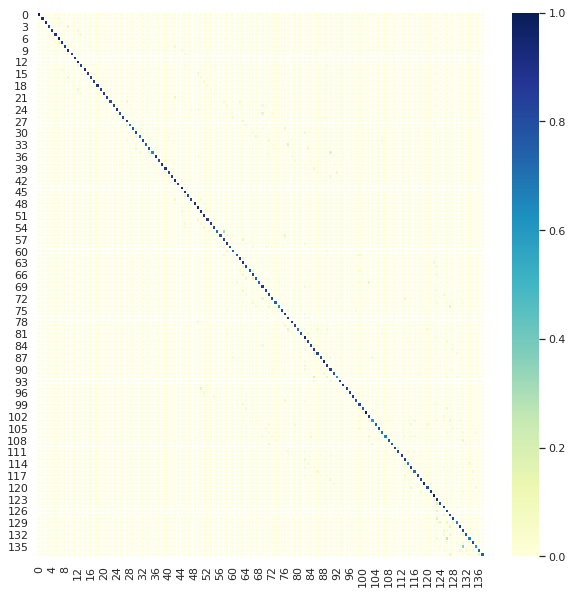

Nonzero percentage:  8.21 %


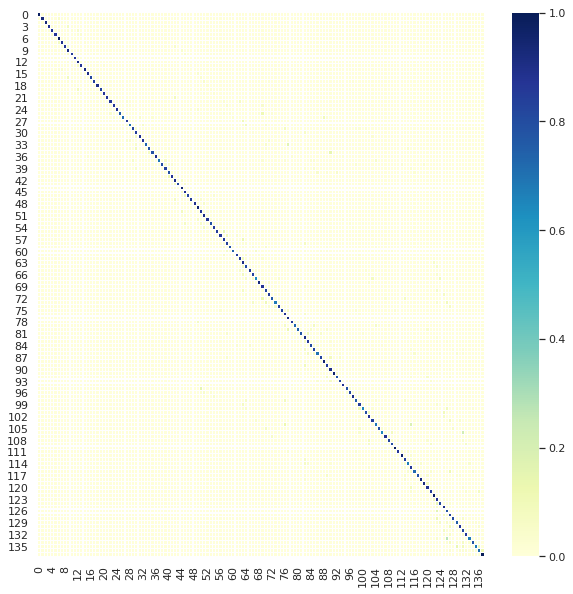

Nonzero percentage:  8.27 %


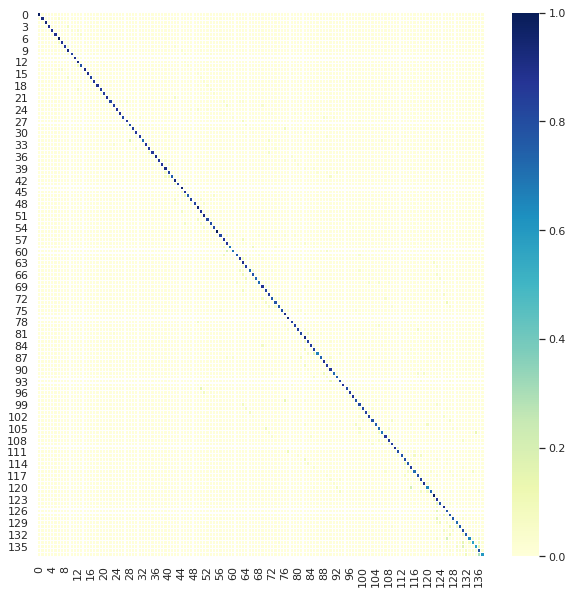

Nonzero percentage:  7.91 %


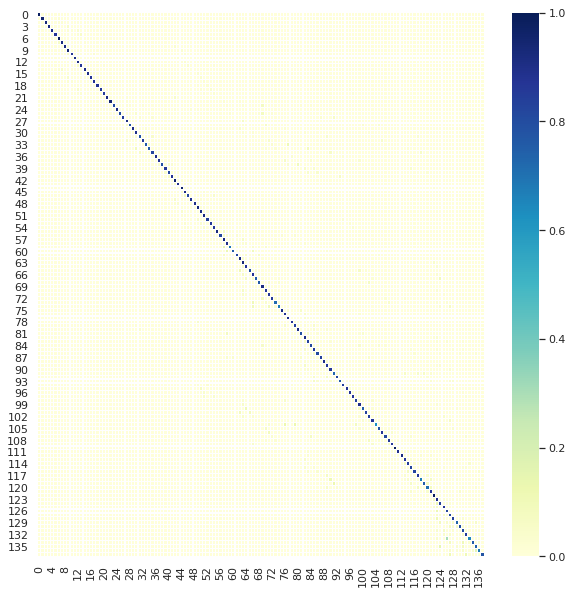

Nonzero percentage:  7.51 %


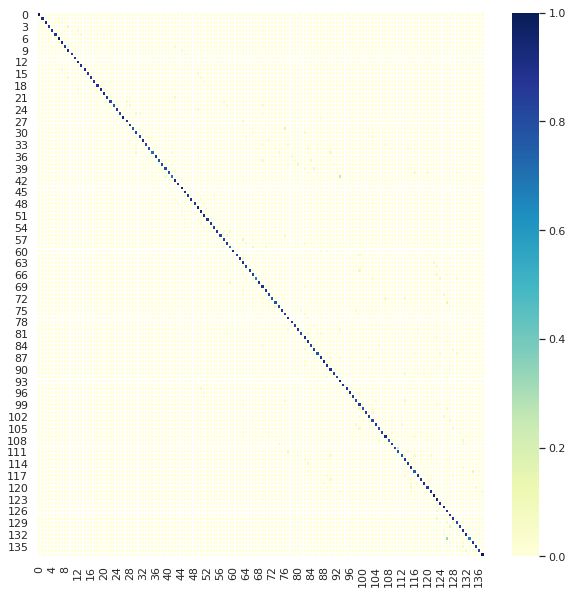

Nonzero percentage:  7.37 %


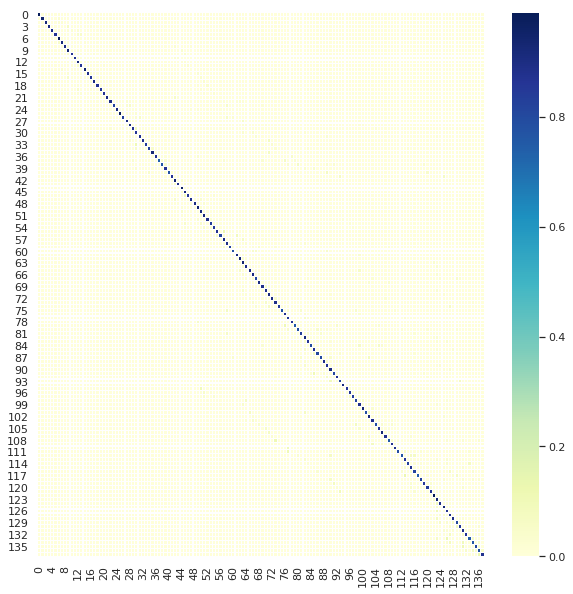

Nonzero percentage:  8.57 %


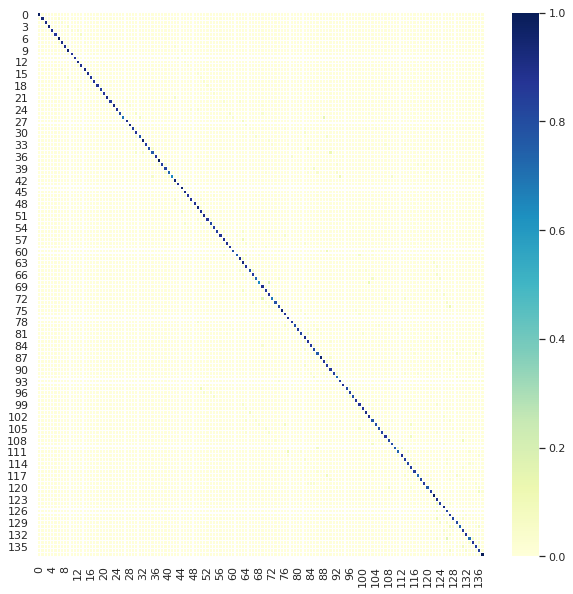

Nonzero percentage:  7.18 %


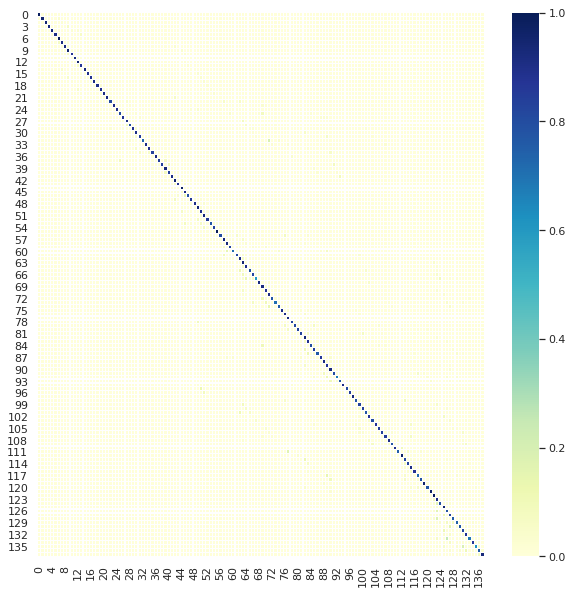

Nonzero percentage:  7.44 %


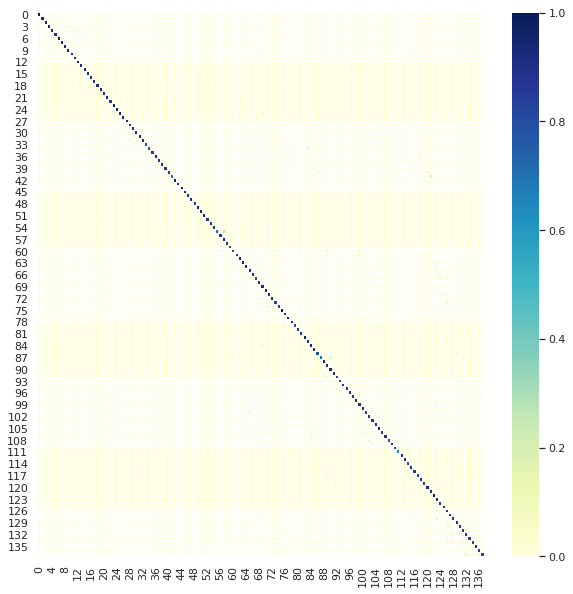

Nonzero percentage:  7.15 %


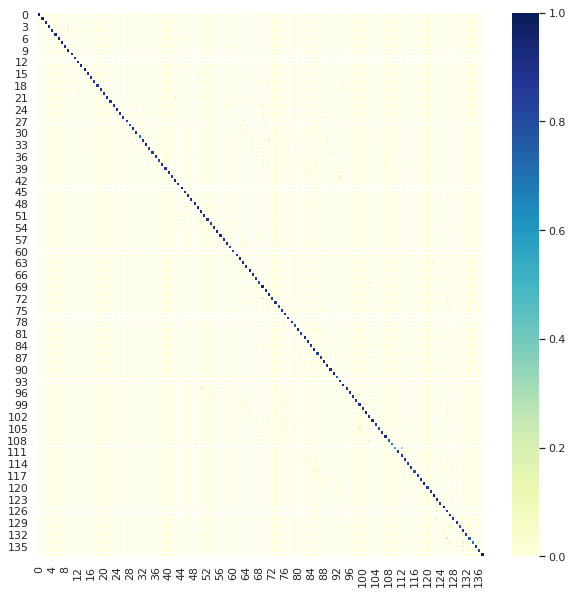

Nonzero percentage:  8.06 %


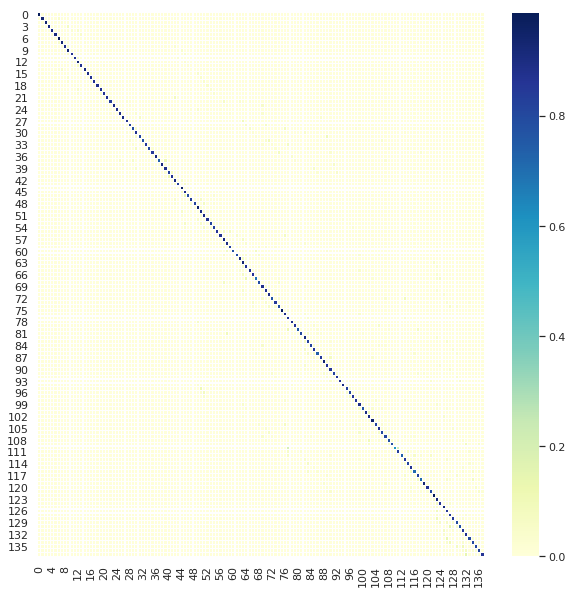

Nonzero percentage:  6.94 %


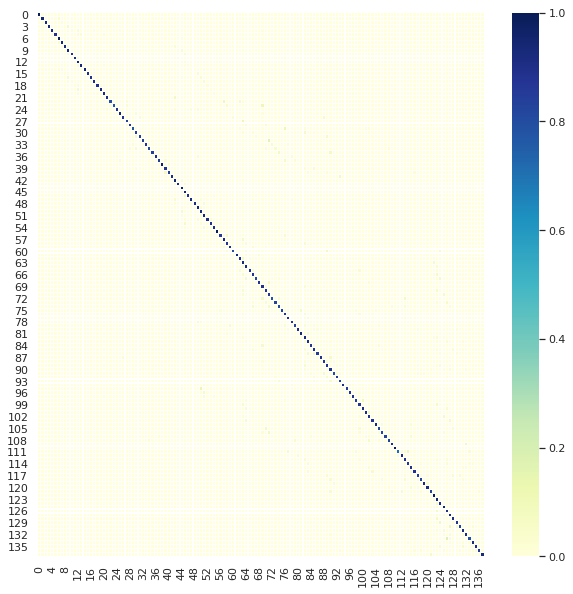

Nonzero percentage:  8.27 %


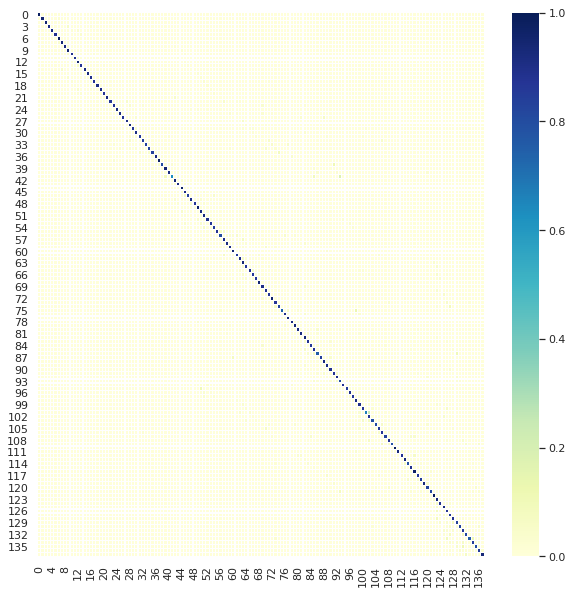

Nonzero percentage:  6.99 %


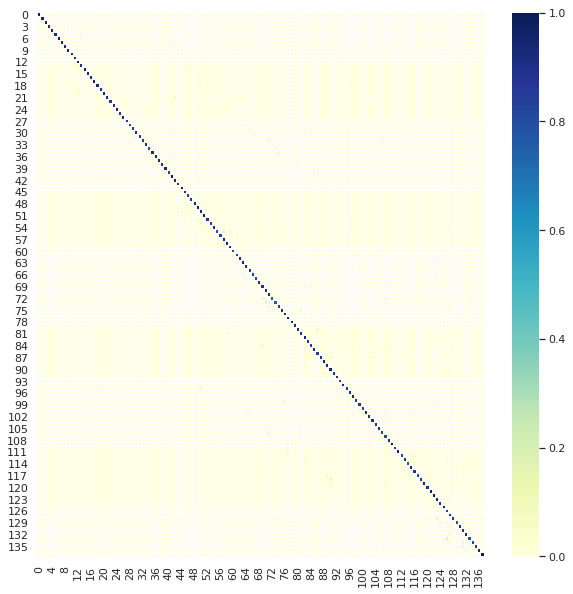

Nonzero percentage:  7.78 %


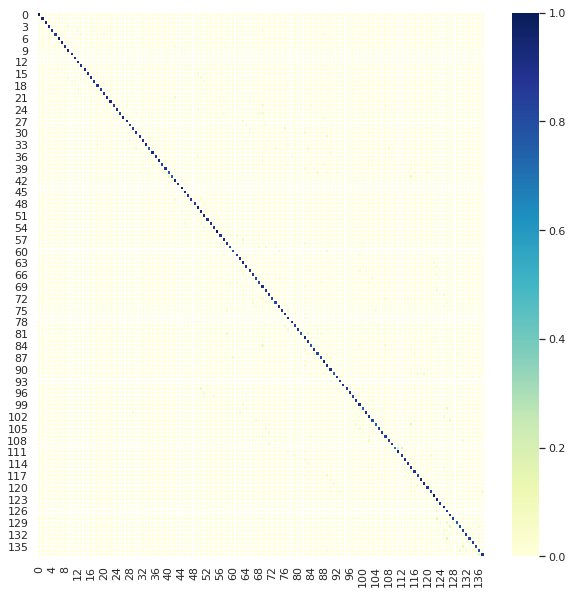

Nonzero percentage:  7.28 %


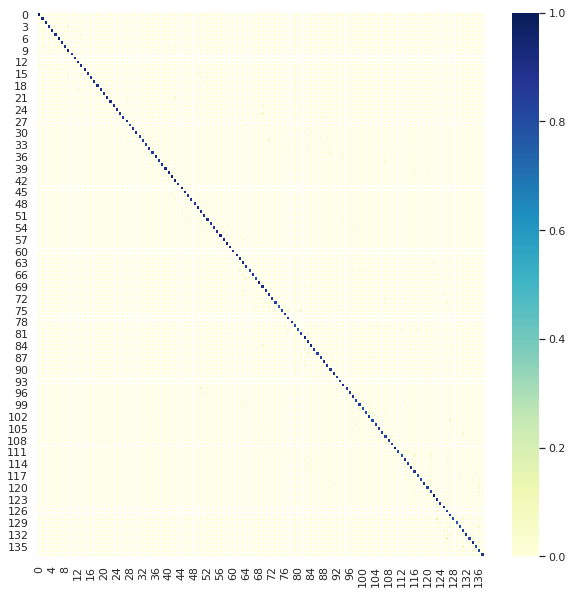

Nonzero percentage:  7.29 %


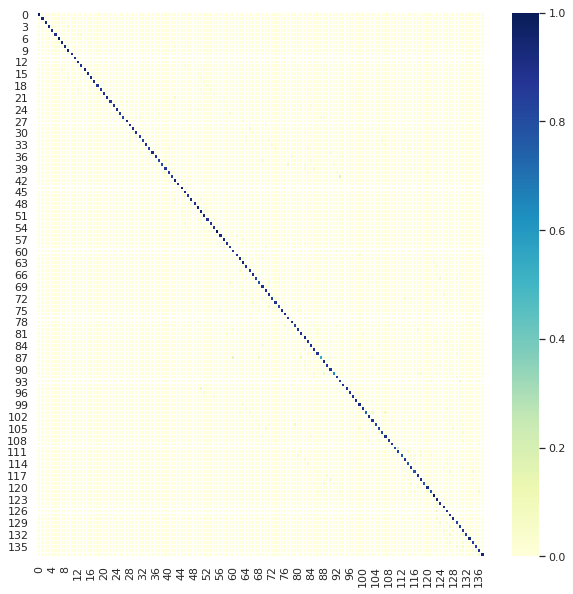

Nonzero percentage:  8.23 %


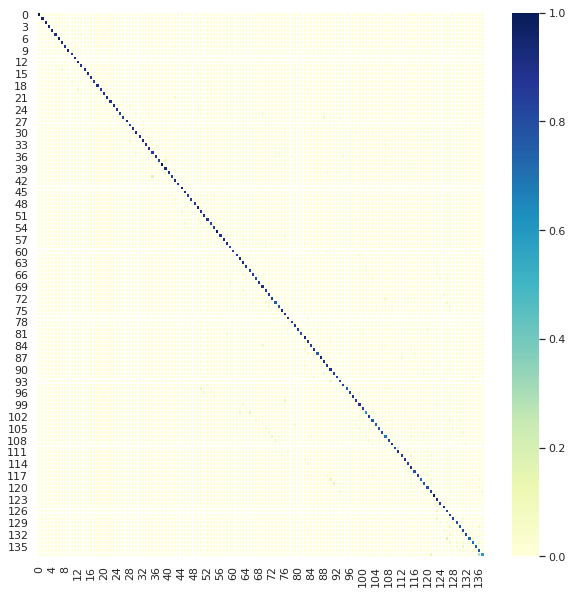

Nonzero percentage:  7.83 %


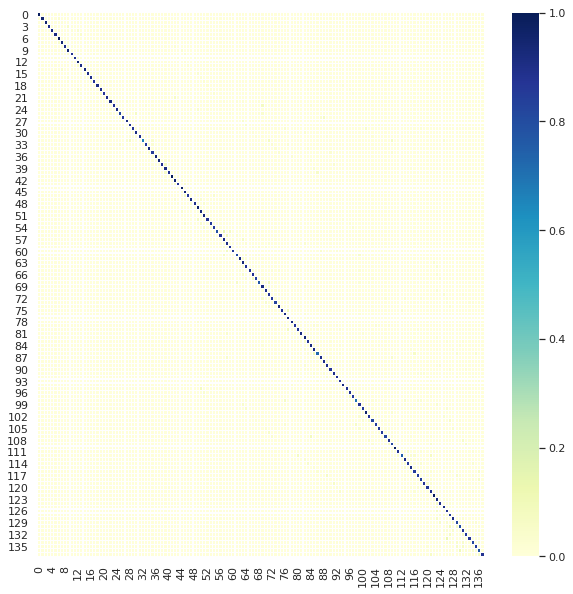

Nonzero percentage:  6.86 %


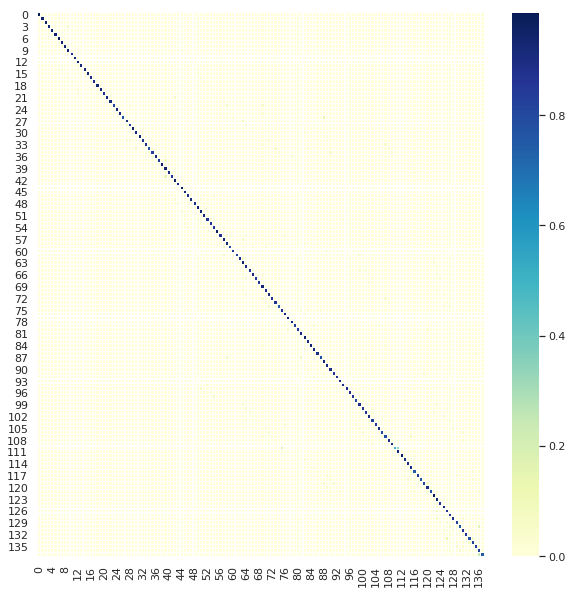

Nonzero percentage:  7.02 %


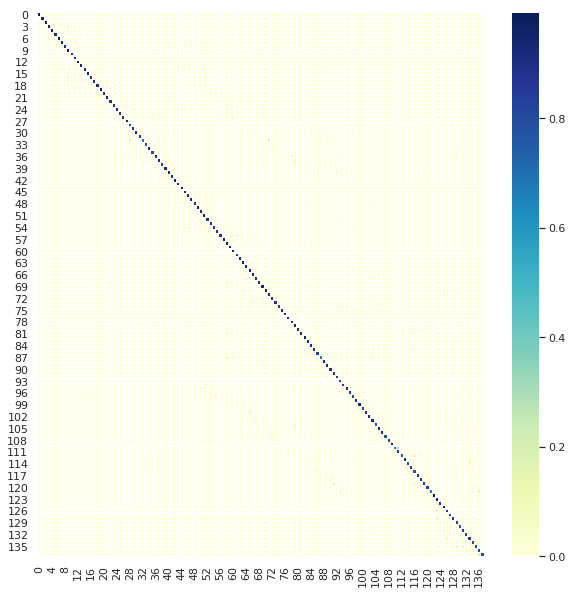

Nonzero percentage:  6.73 %


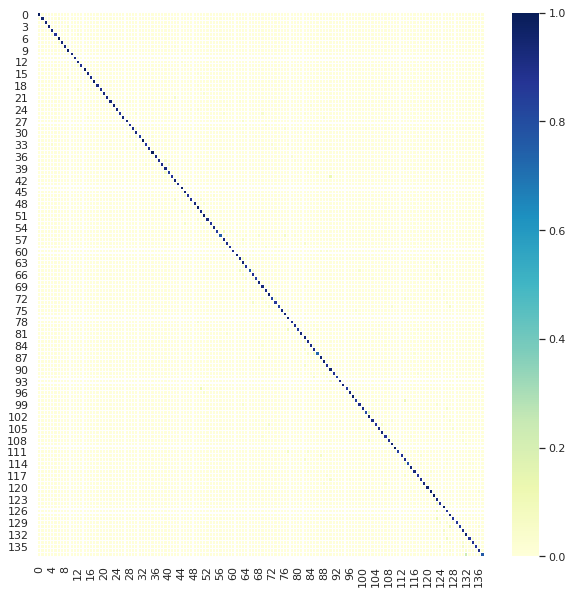

Nonzero percentage:  6.53 %


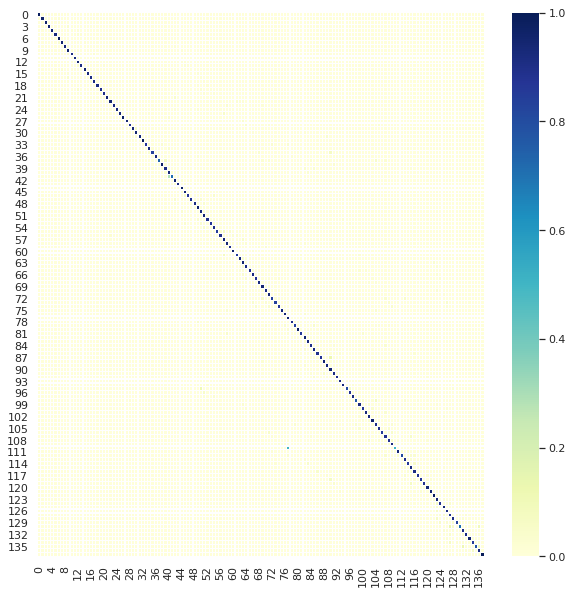

Nonzero percentage:  7.63 %


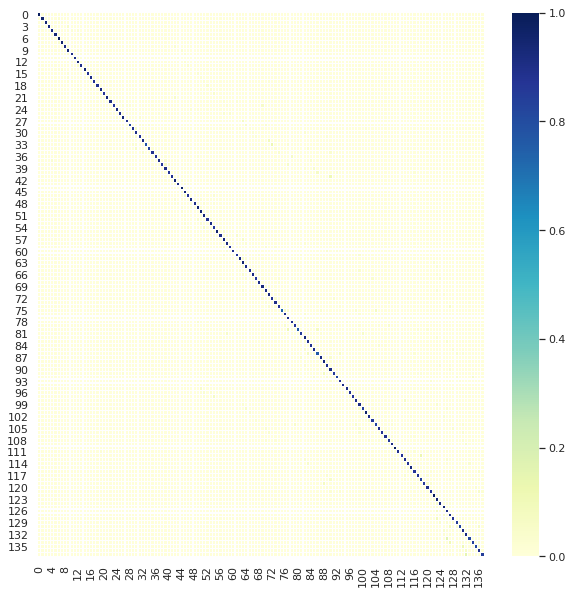

Nonzero percentage:  6.71 %


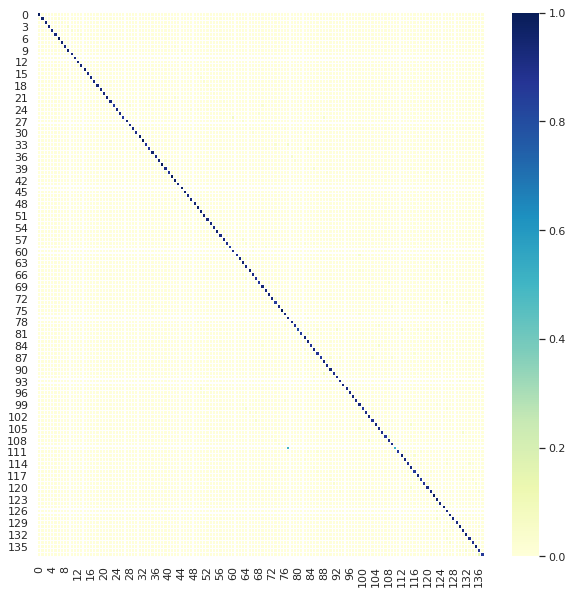

Nonzero percentage:  7.21 %


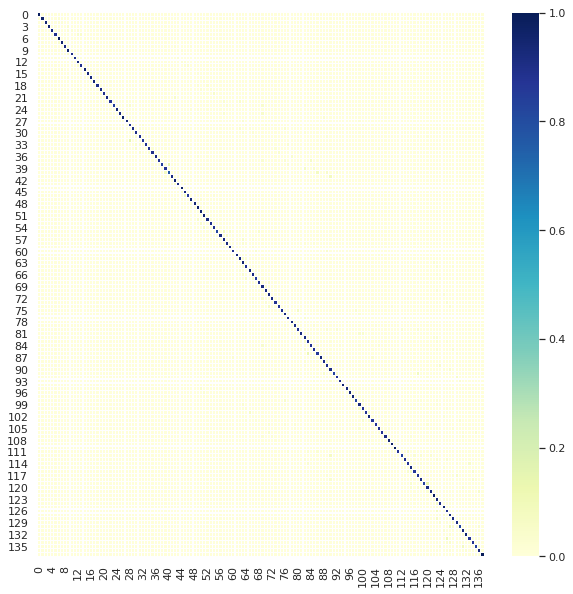

Nonzero percentage:  7.12 %


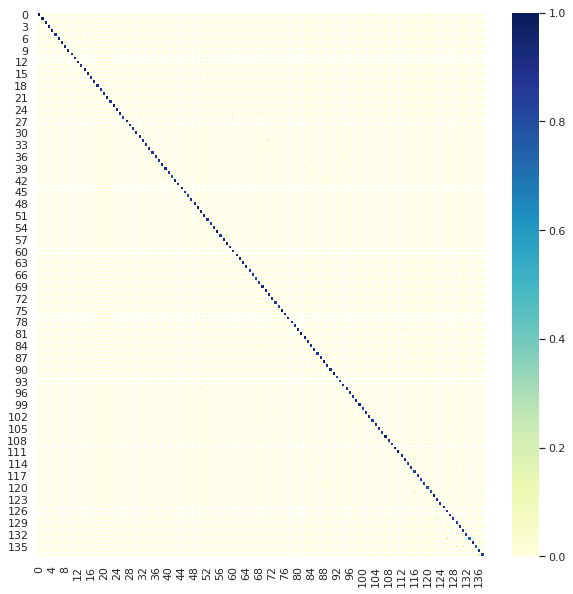

Nonzero percentage:  7.44 %


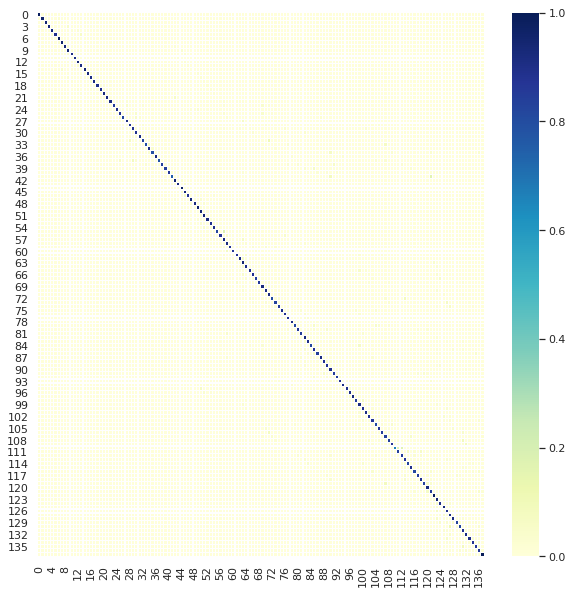

Nonzero percentage:  5.68 %


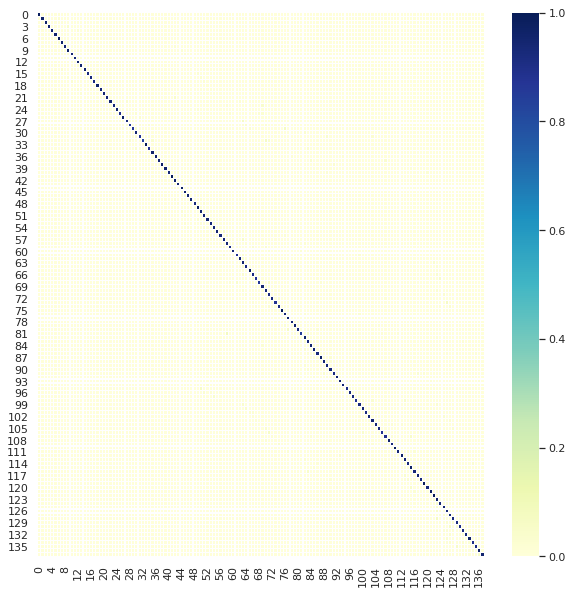

Nonzero percentage:  5.85 %


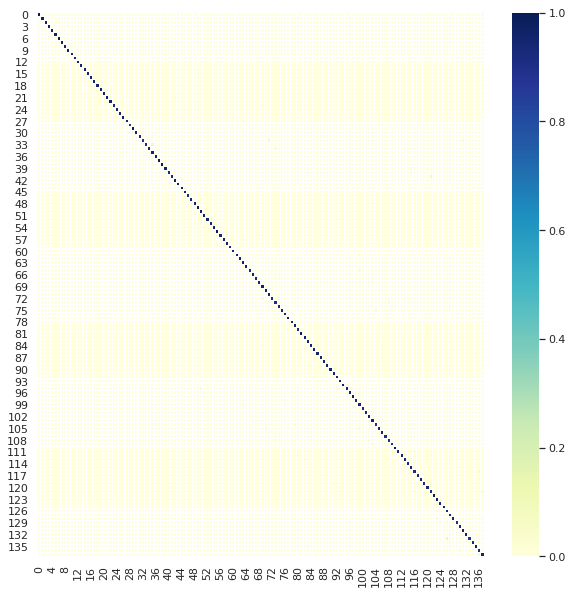

Nonzero percentage:  6.34 %


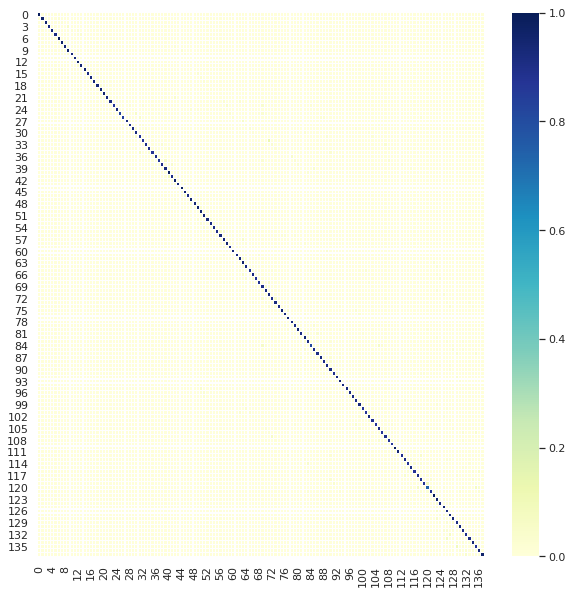

Nonzero percentage:  6.15 %


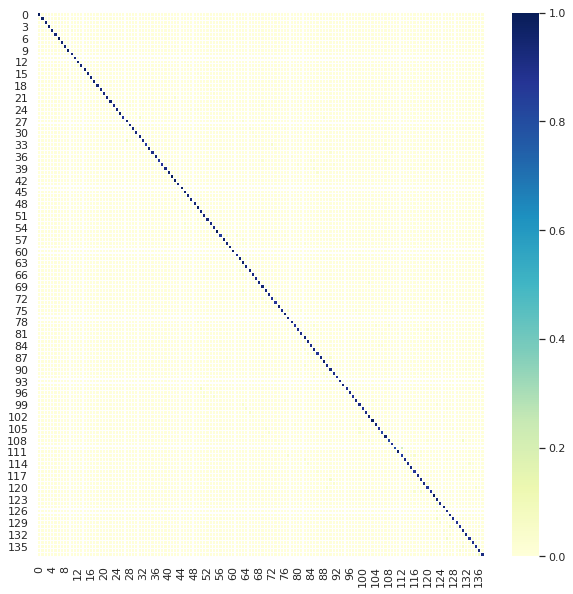

Nonzero percentage:  6.79 %


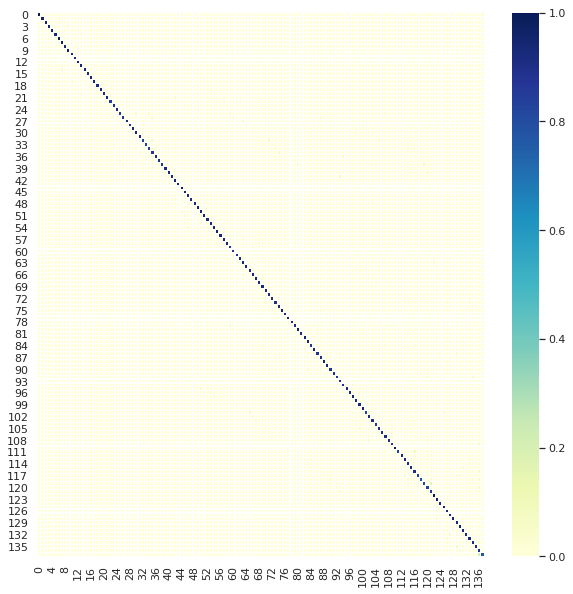

Nonzero percentage:  5.02 %


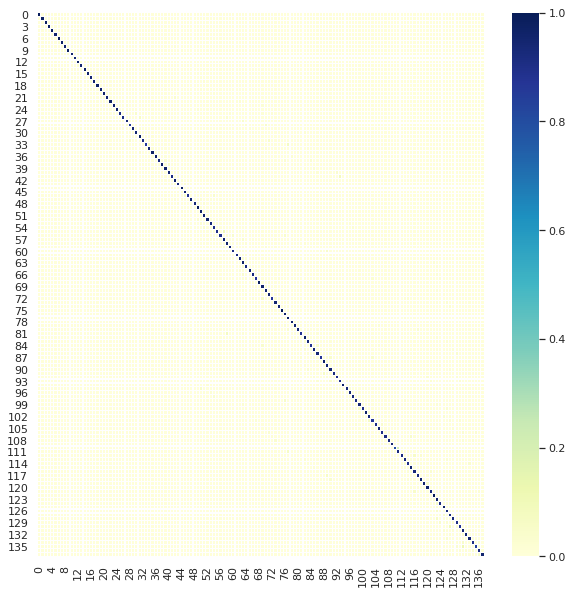

Nonzero percentage:  6.51 %


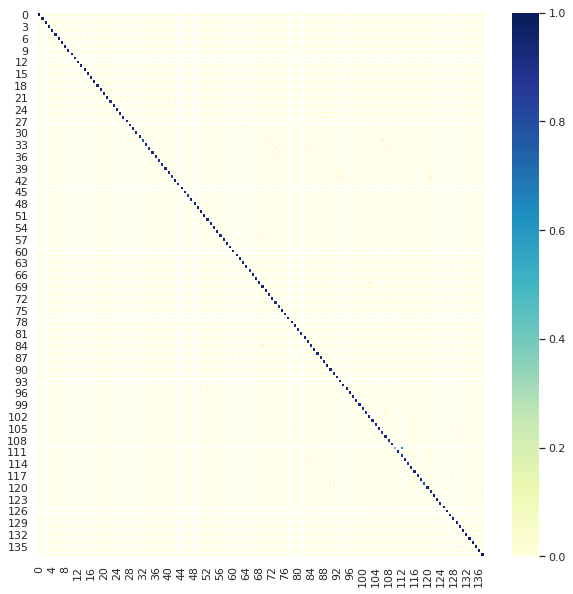

Nonzero percentage:  5.84 %


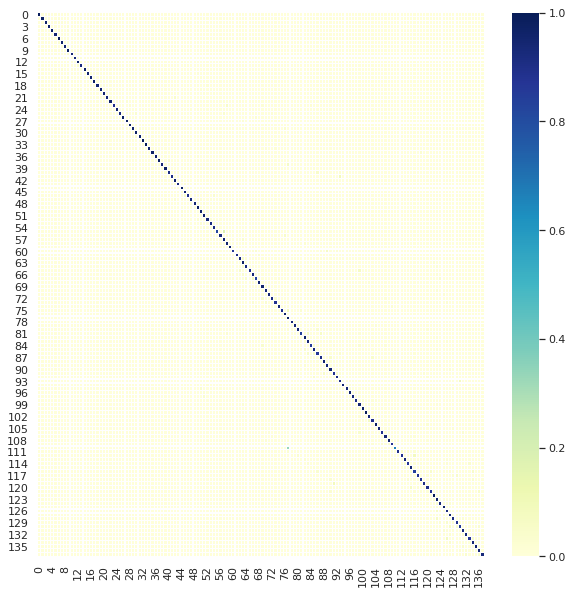

Nonzero percentage:  5.77 %


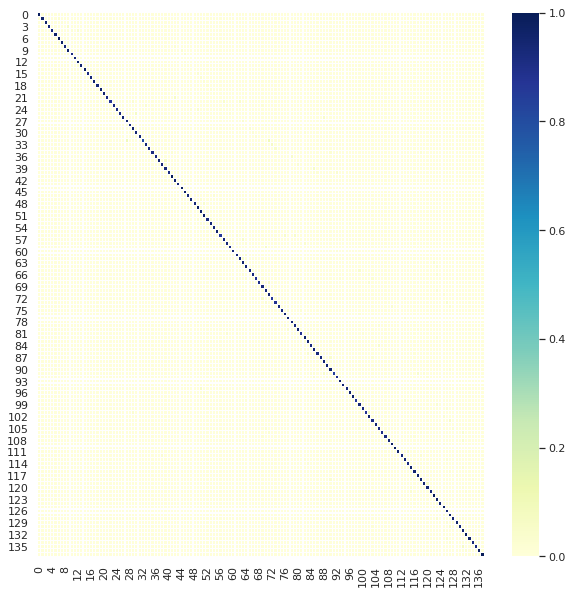

Nonzero percentage:  5.84 %


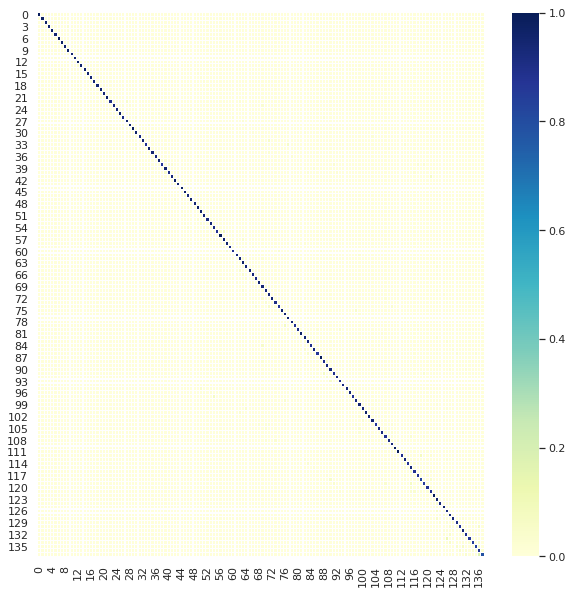

Nonzero percentage:  6.22 %


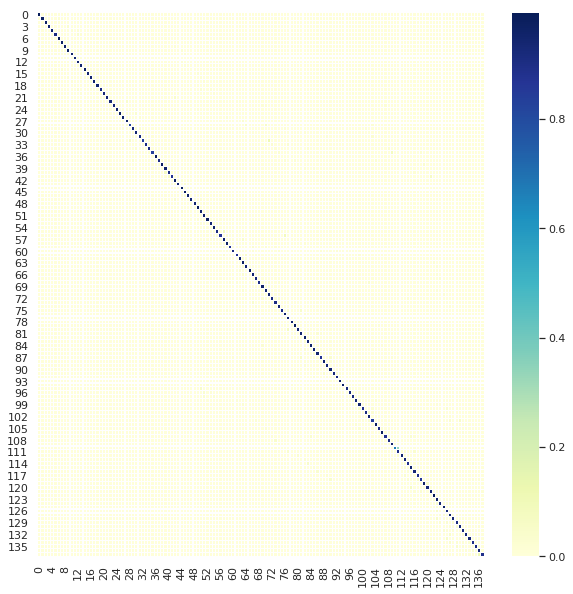

Nonzero percentage:  7.13 %


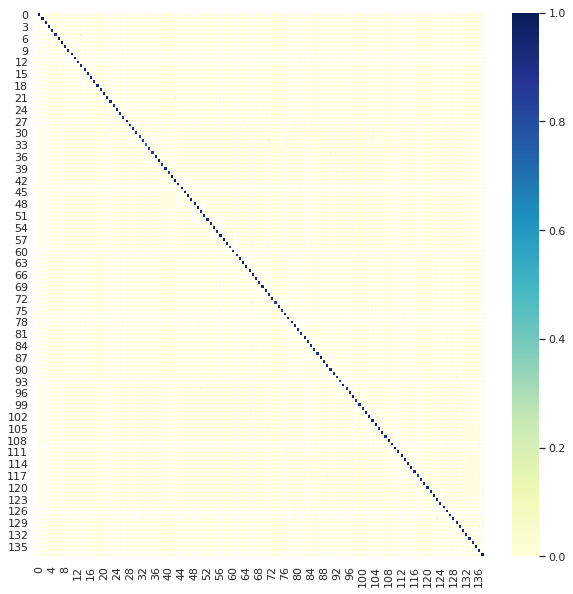

Nonzero percentage:  5.79 %


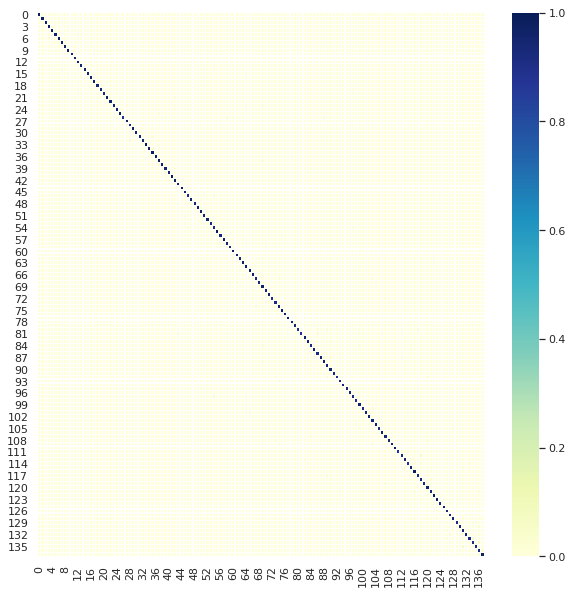

Nonzero percentage:  5.42 %


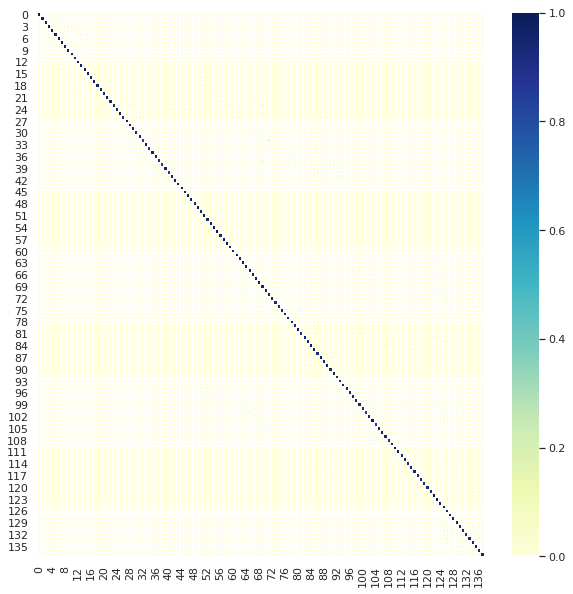

Nonzero percentage:  6.22 %


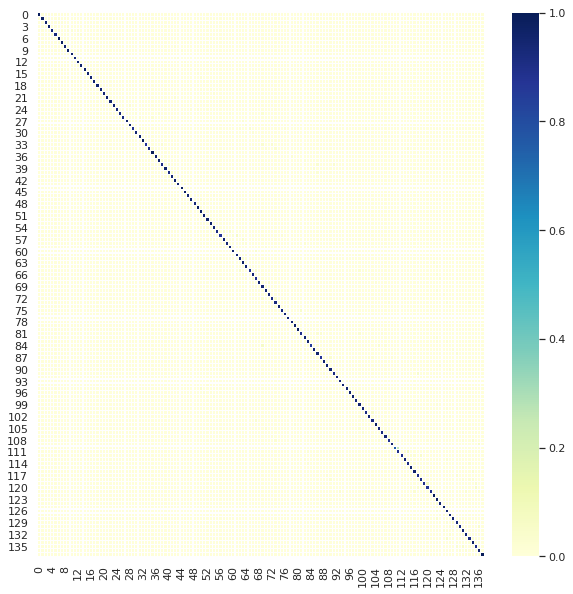

Nonzero percentage:  5.76 %


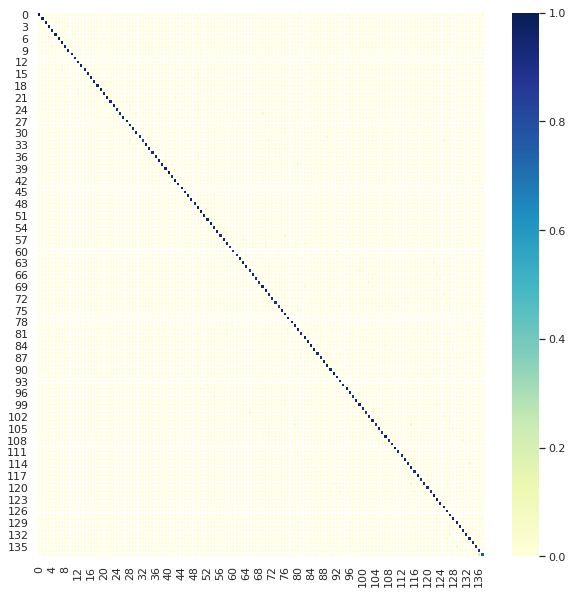

Nonzero percentage:  5.49 %


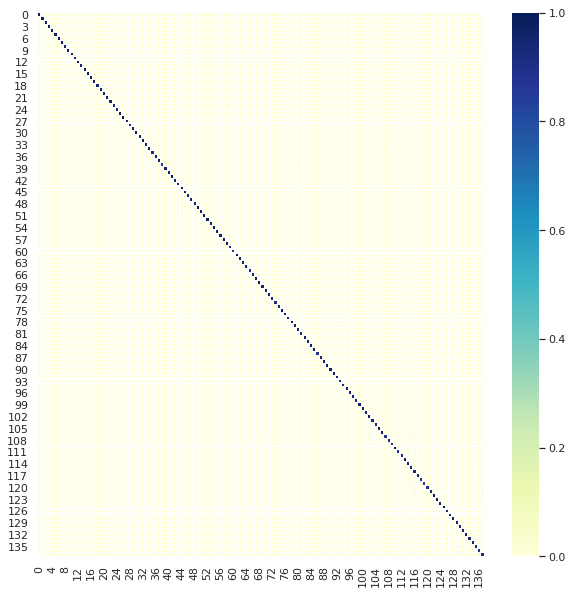

Nonzero percentage:  4.98 %


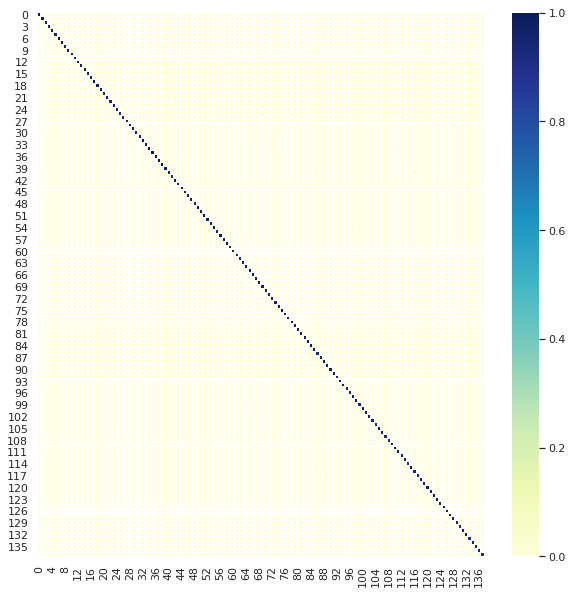

Nonzero percentage:  5.3 %


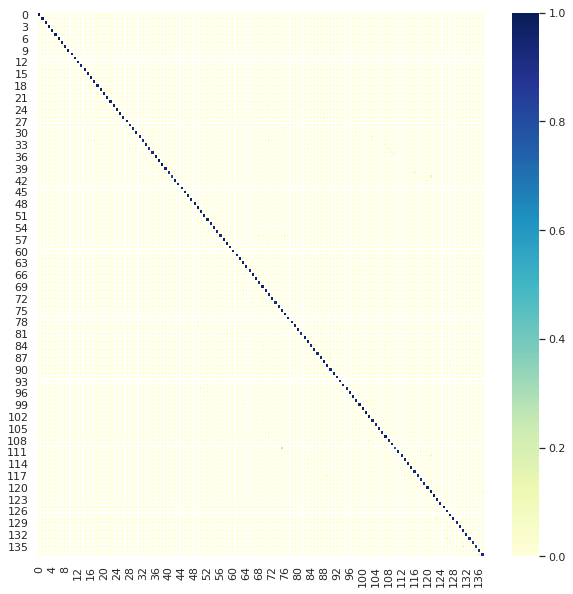

Nonzero percentage:  5.11 %


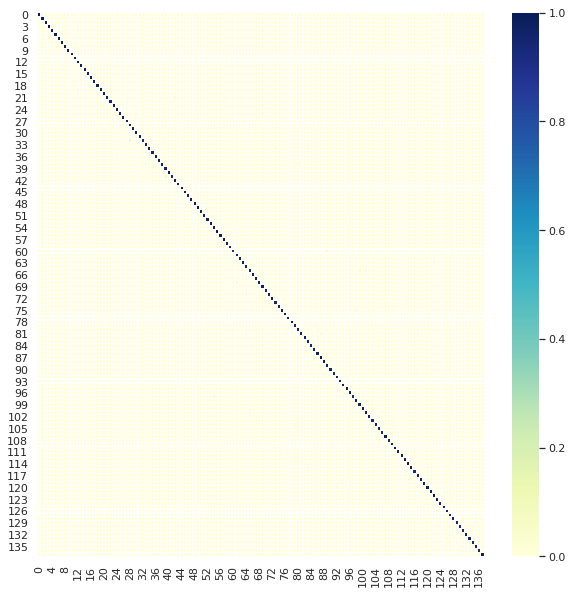

Nonzero percentage:  4.75 %


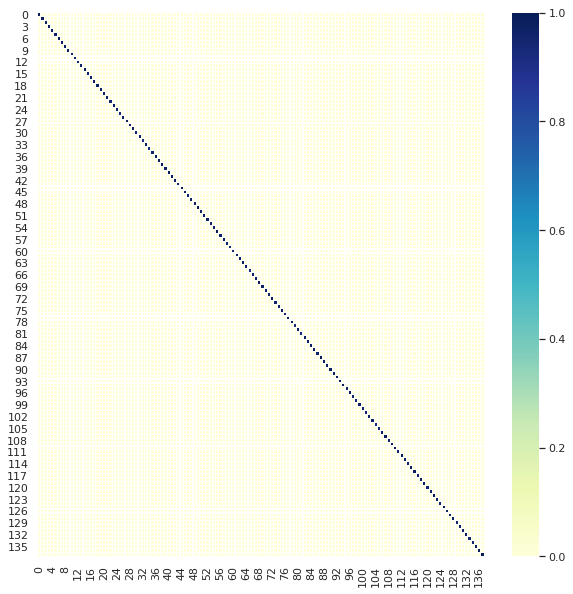

Nonzero percentage:  5.63 %


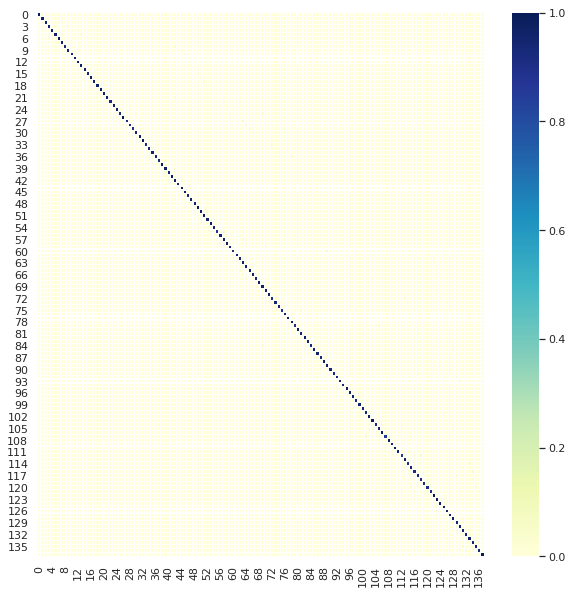

Nonzero percentage:  5.05 %


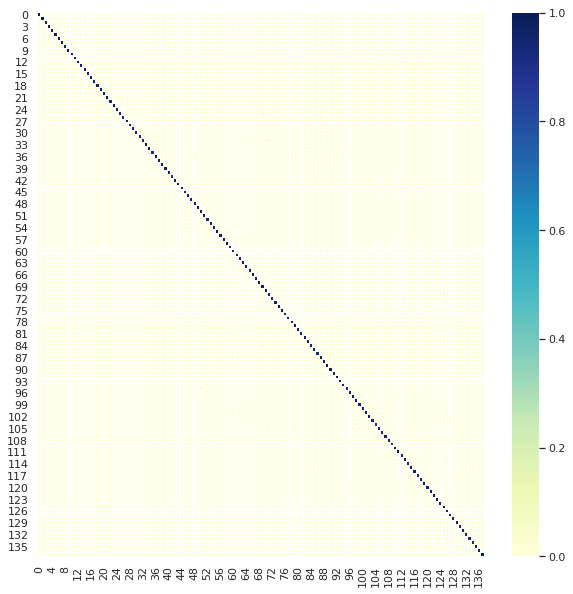

Nonzero percentage:  5.46 %


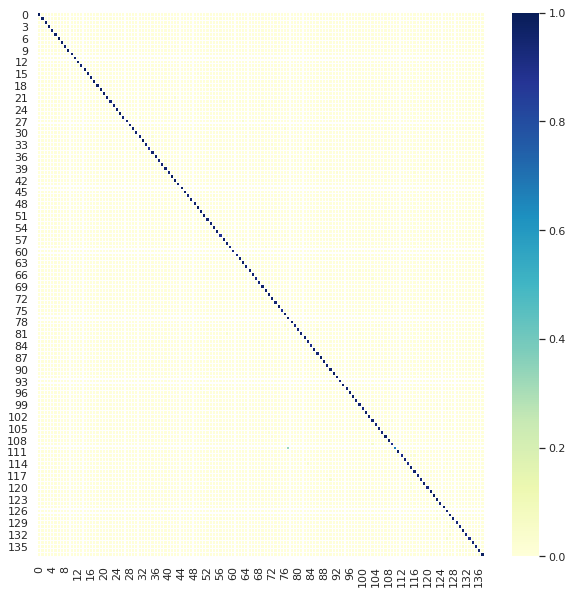

Nonzero percentage:  5.51 %


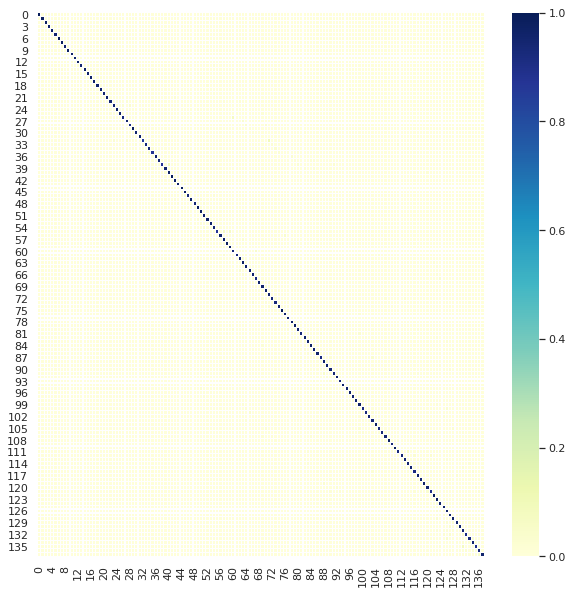

Nonzero percentage:  5.18 %


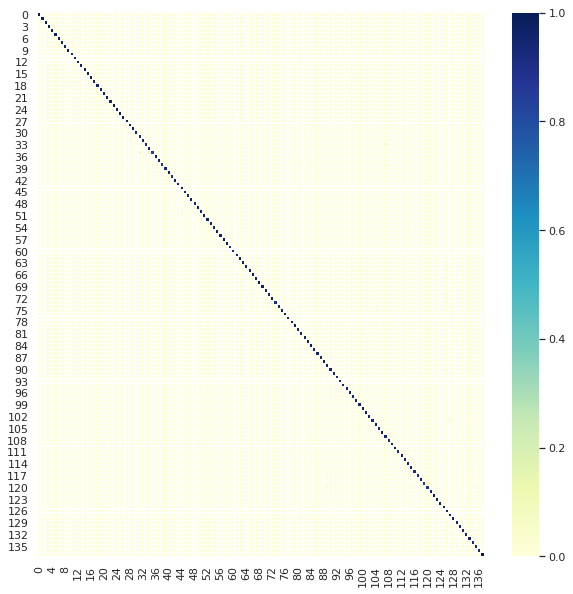

Nonzero percentage:  4.67 %


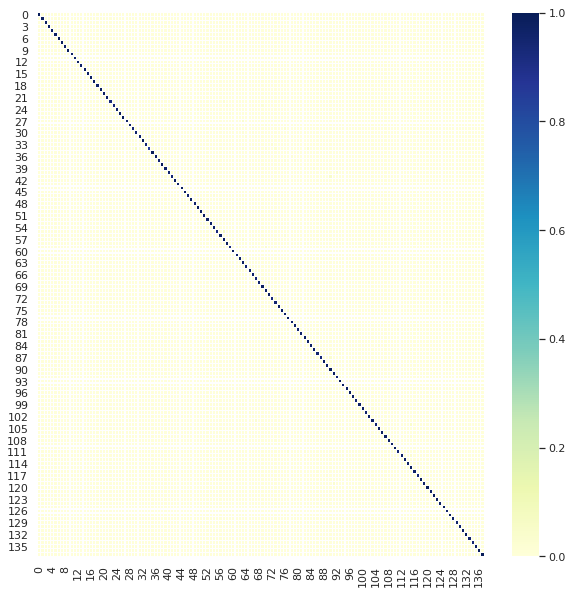

Nonzero percentage:  5.36 %


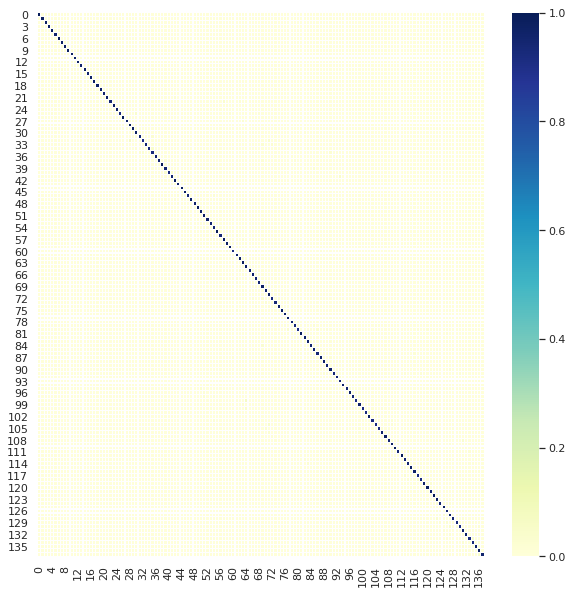

Nonzero percentage:  5.03 %


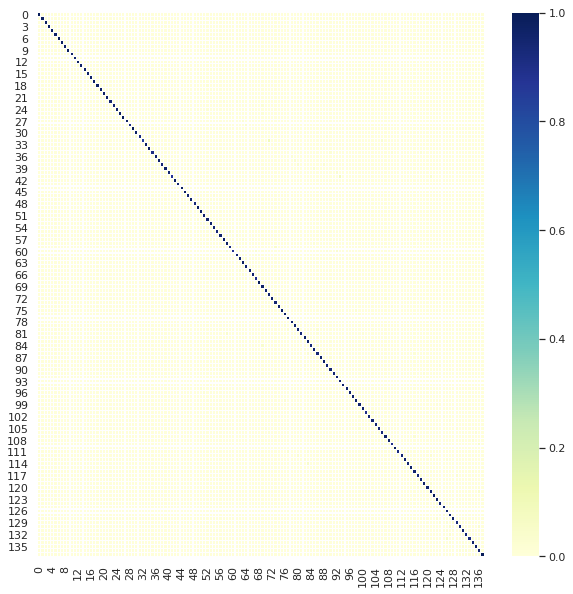

Nonzero percentage:  5.16 %


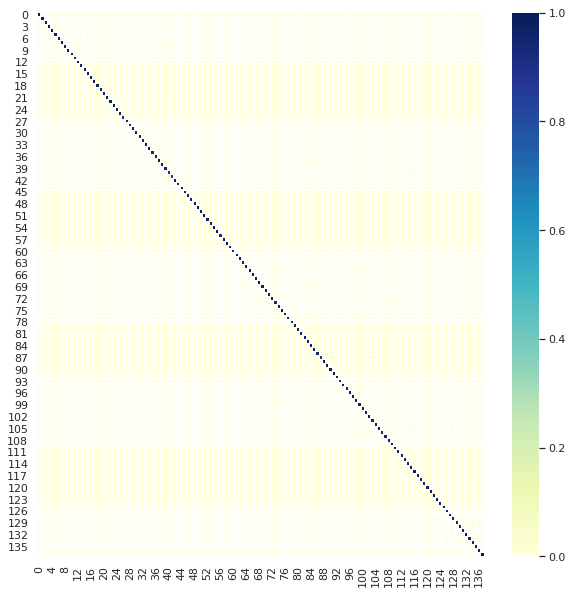

Nonzero percentage:  5.68 %


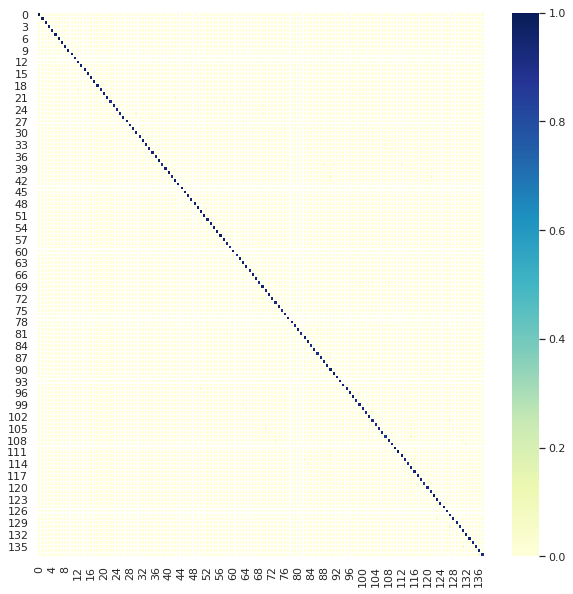

Nonzero percentage:  5.14 %


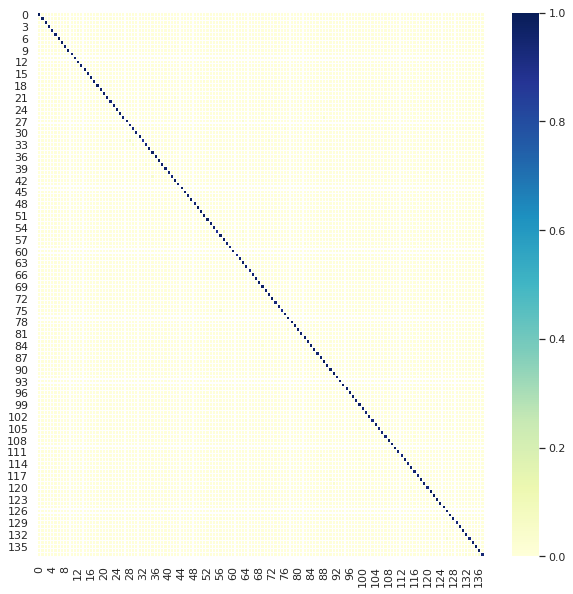

Nonzero percentage:  5.02 %


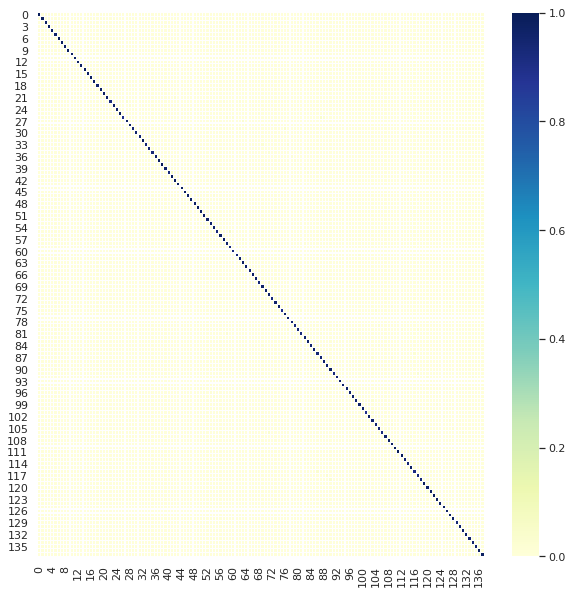

Nonzero percentage:  5.37 %


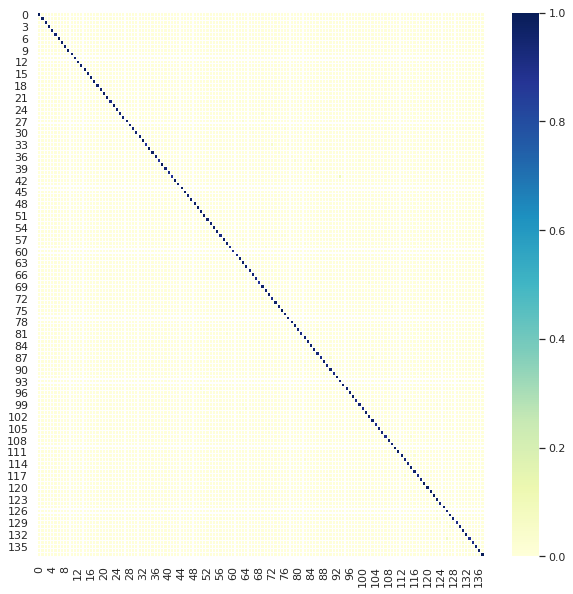

Nonzero percentage:  5.51 %


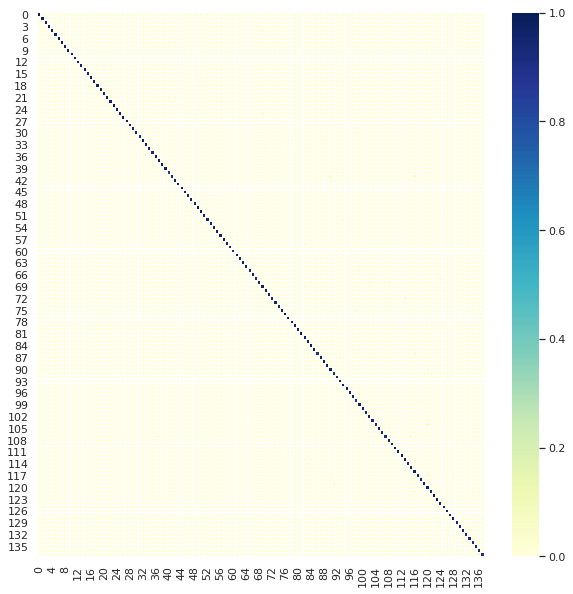

Nonzero percentage:  5.09 %


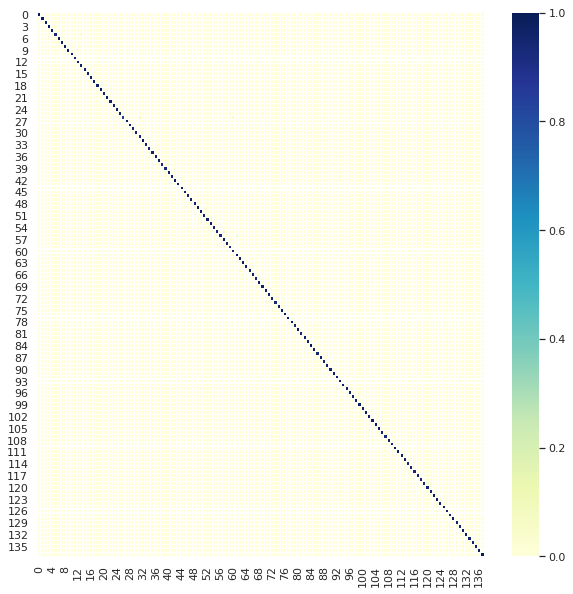

Nonzero percentage:  6.25 %


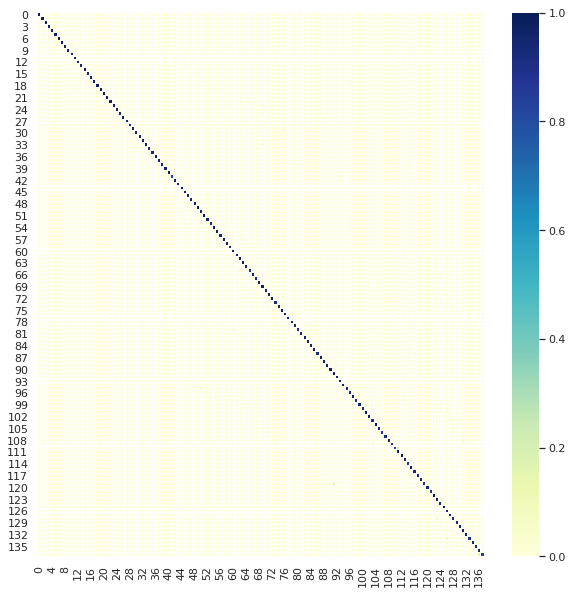

Nonzero percentage:  6.09 %


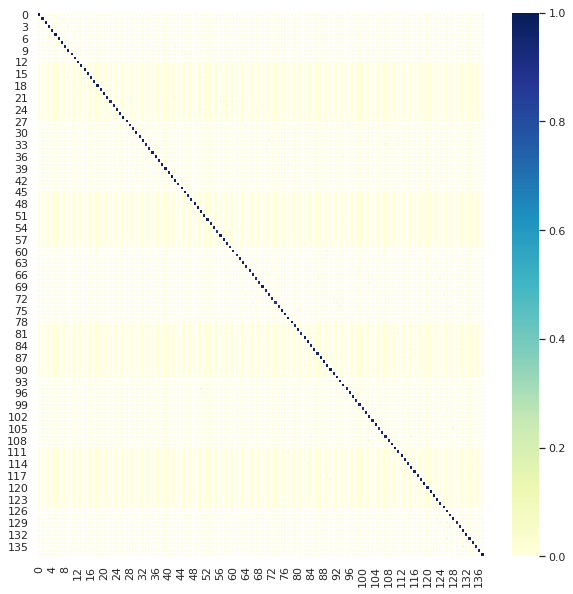

Nonzero percentage:  4.82 %


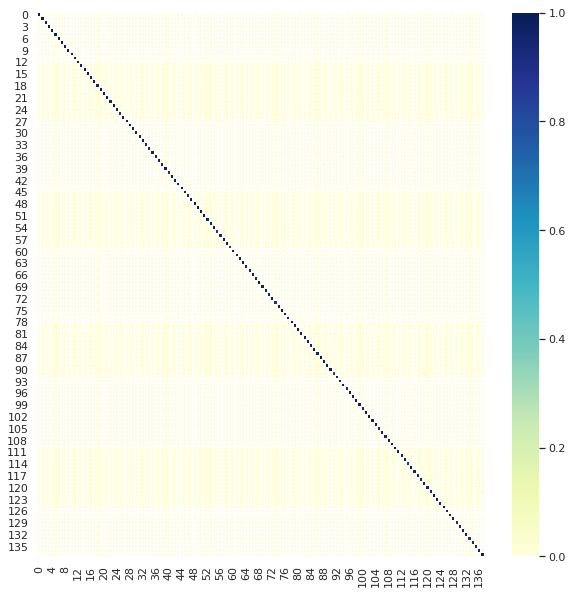

Nonzero percentage:  6.33 %


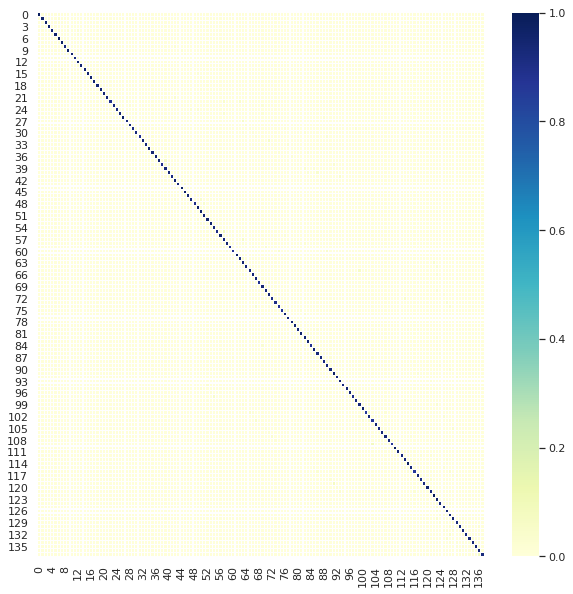

Nonzero percentage:  4.17 %


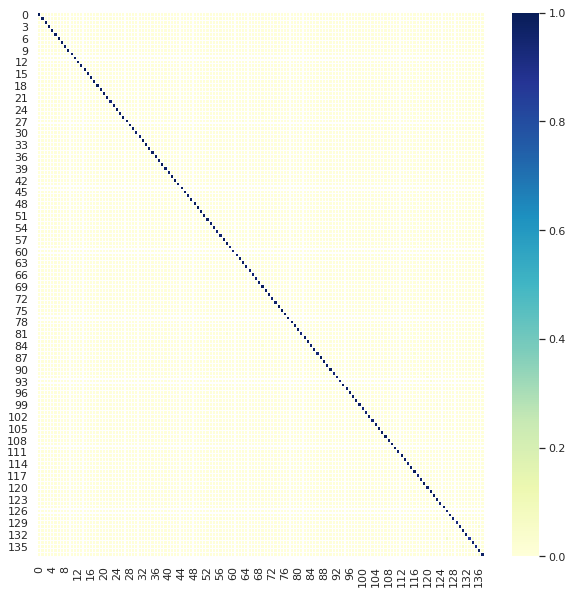

Nonzero percentage:  5.21 %


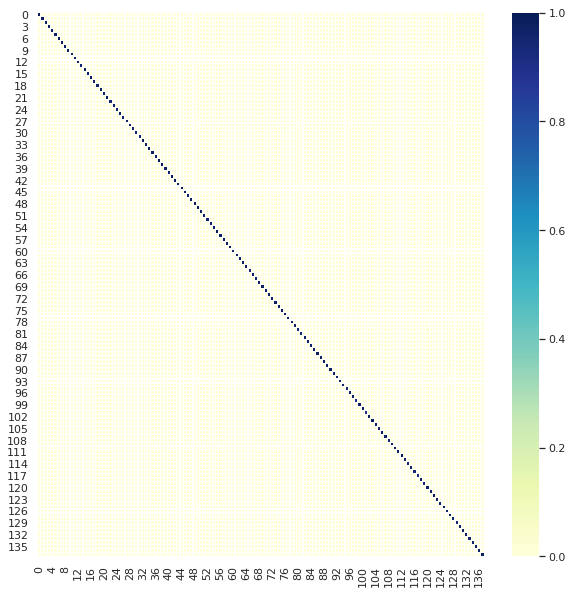

Nonzero percentage:  4.31 %


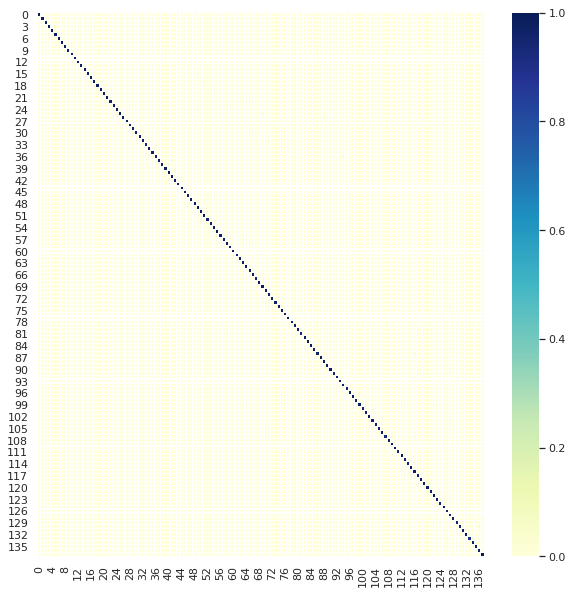

Nonzero percentage:  4.54 %


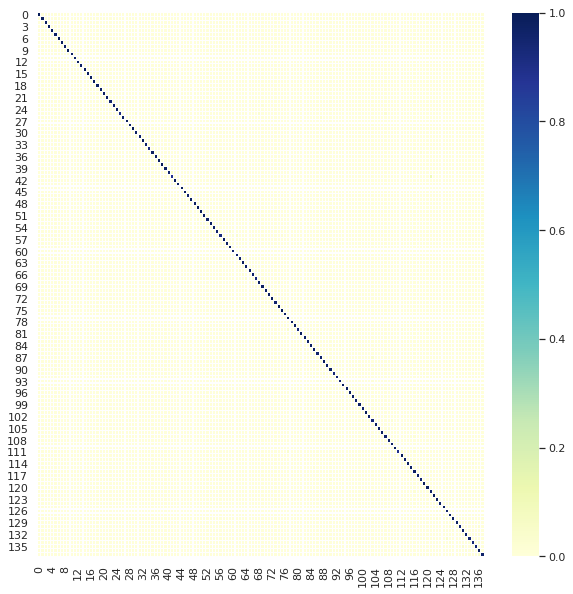

Nonzero percentage:  3.83 %


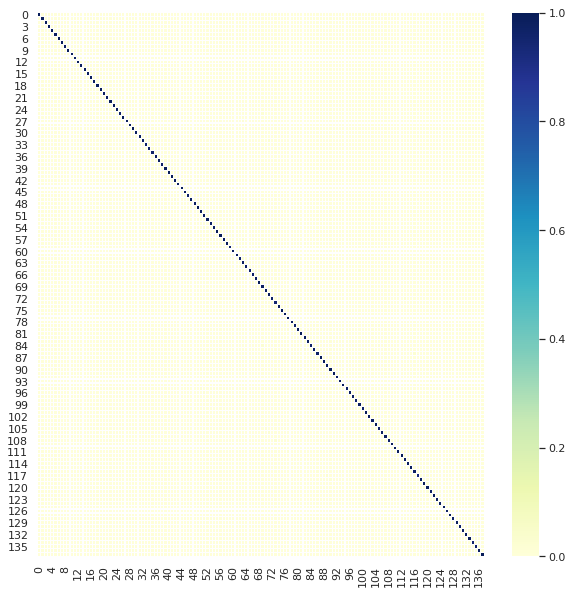

Nonzero percentage:  4.09 %


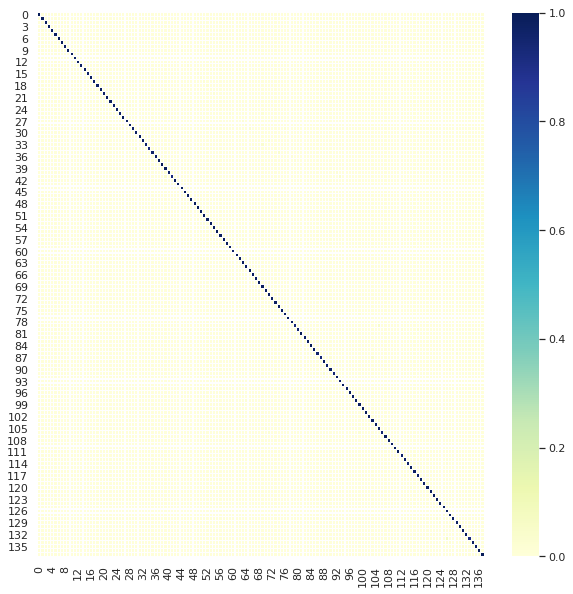

Nonzero percentage:  3.99 %


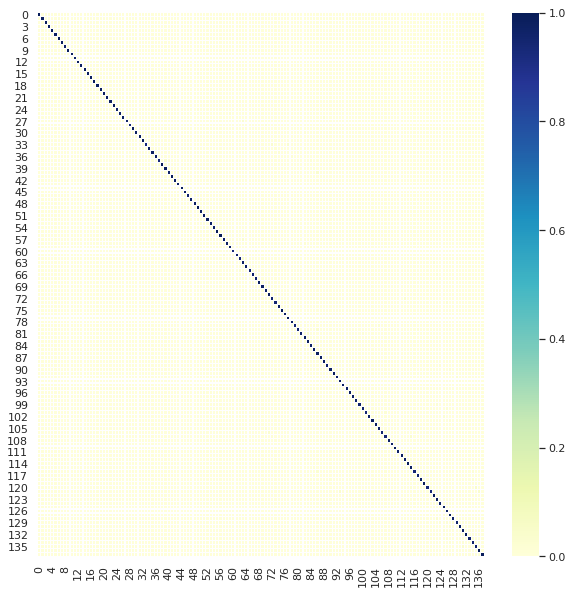

Nonzero percentage:  4.25 %


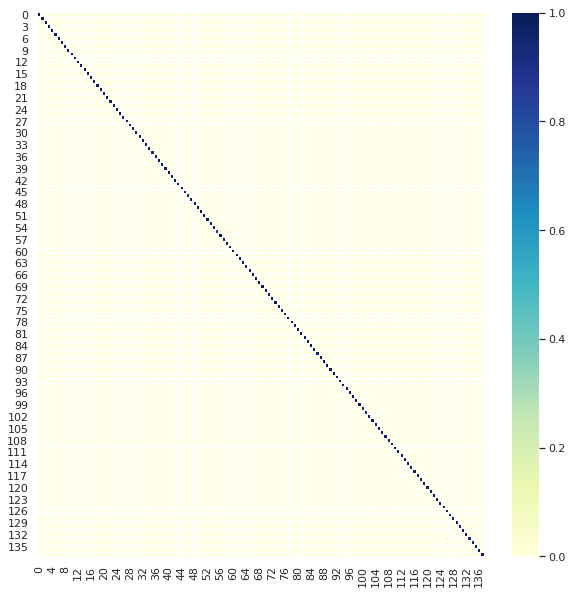

Nonzero percentage:  4.98 %


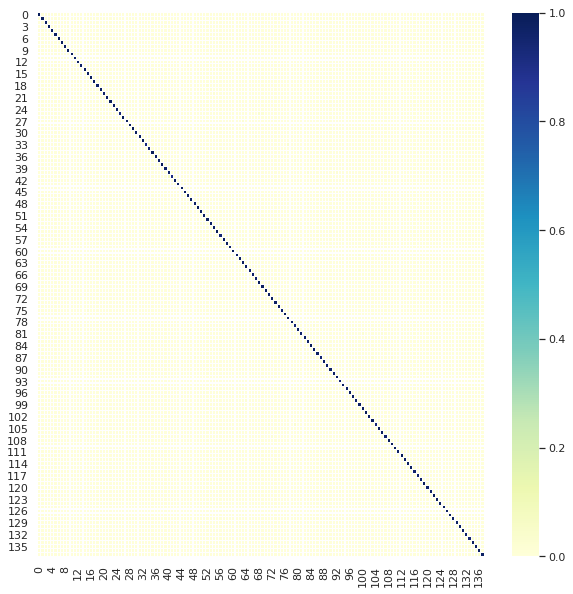

Nonzero percentage:  4.35 %


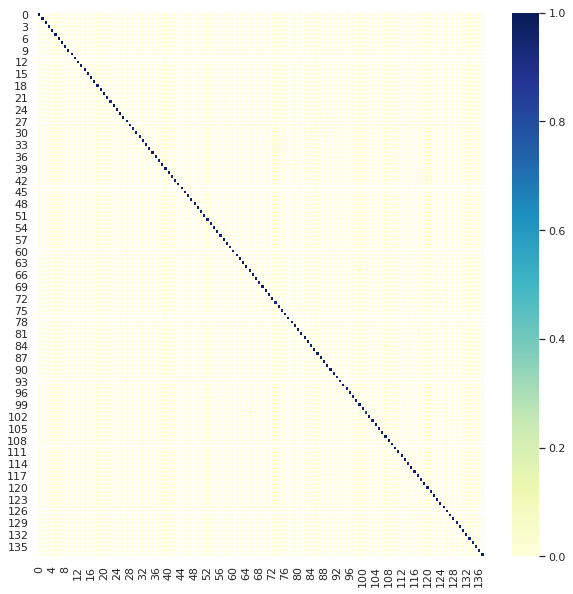

Nonzero percentage:  4.03 %


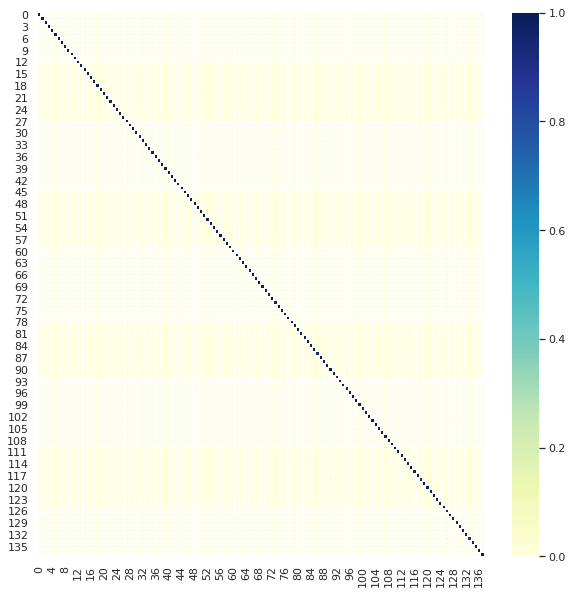

Nonzero percentage:  4.17 %


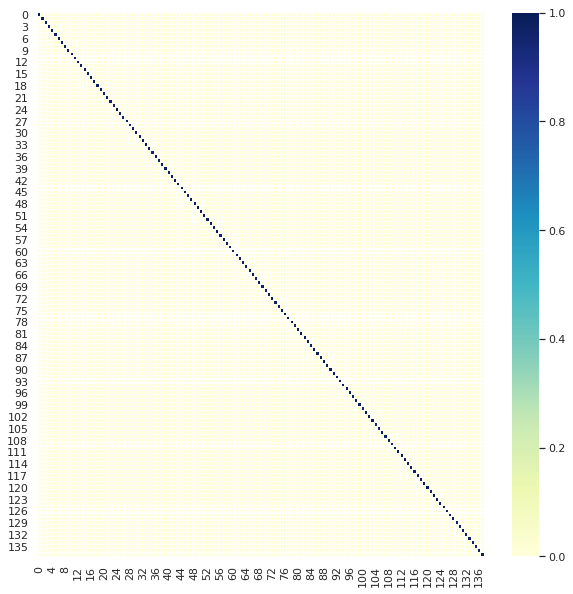

In [43]:
for transition_matrix in acc_result['transition_matrices']:
    sns.set(rc={'figure.figsize': (10, 10)})
    print('Nonzero percentage: ', round(100 * len(np.where(transition_matrix > 0)[0]) / (unique_triad_num * unique_triad_num), 2), '%')
    sns.heatmap(transition_matrix, cmap="YlGnBu", linewidths=.1)
    plt.show()

In [ ]:
# for transition_matrix in acc_result['transition_matrices']:
#     sns.set(rc={'figure.figsize': (8, 8)})
#     plt.plot(np.sum(transition_matrix, axis=0))

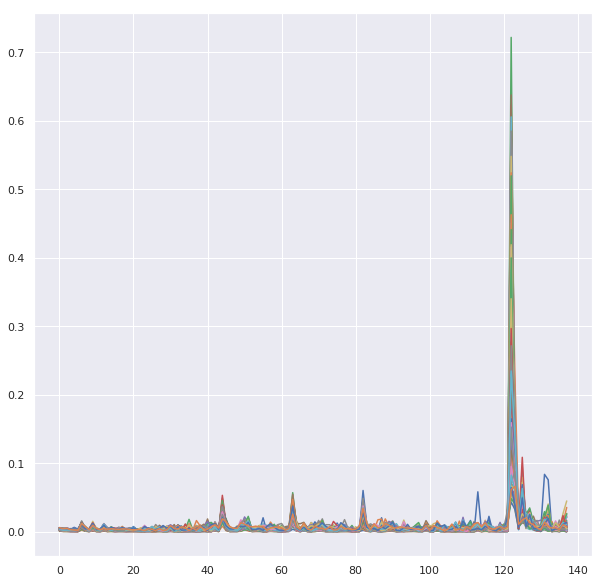

In [44]:
sns.set(rc={'figure.figsize': (10, 10)})
st_dists = []
for transition_matrix in acc_result['transition_matrices']:
    st_dist = network_utils.get_stationary_distribution(transition_matrix)
    st_dists.append(st_dist)
    plt.plot(st_dist)
# plt.legend(['P'+str(i) for i in range(1, 1+len(acc_result['transition_matrices']))])

In [45]:
acc_mean_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
acc_std_transition_matrix = np.zeros(
    (unique_triad_num, unique_triad_num))
for i in range(unique_triad_num):
    for j in range(unique_triad_num):
        item_ij = []
        for matrix in acc_result['transition_matrices']:
            item_ij.append(matrix[i, j])
        acc_mean_transition_matrix[i, j] = np.mean(item_ij)
        acc_std_transition_matrix[i, j] = np.std(item_ij)

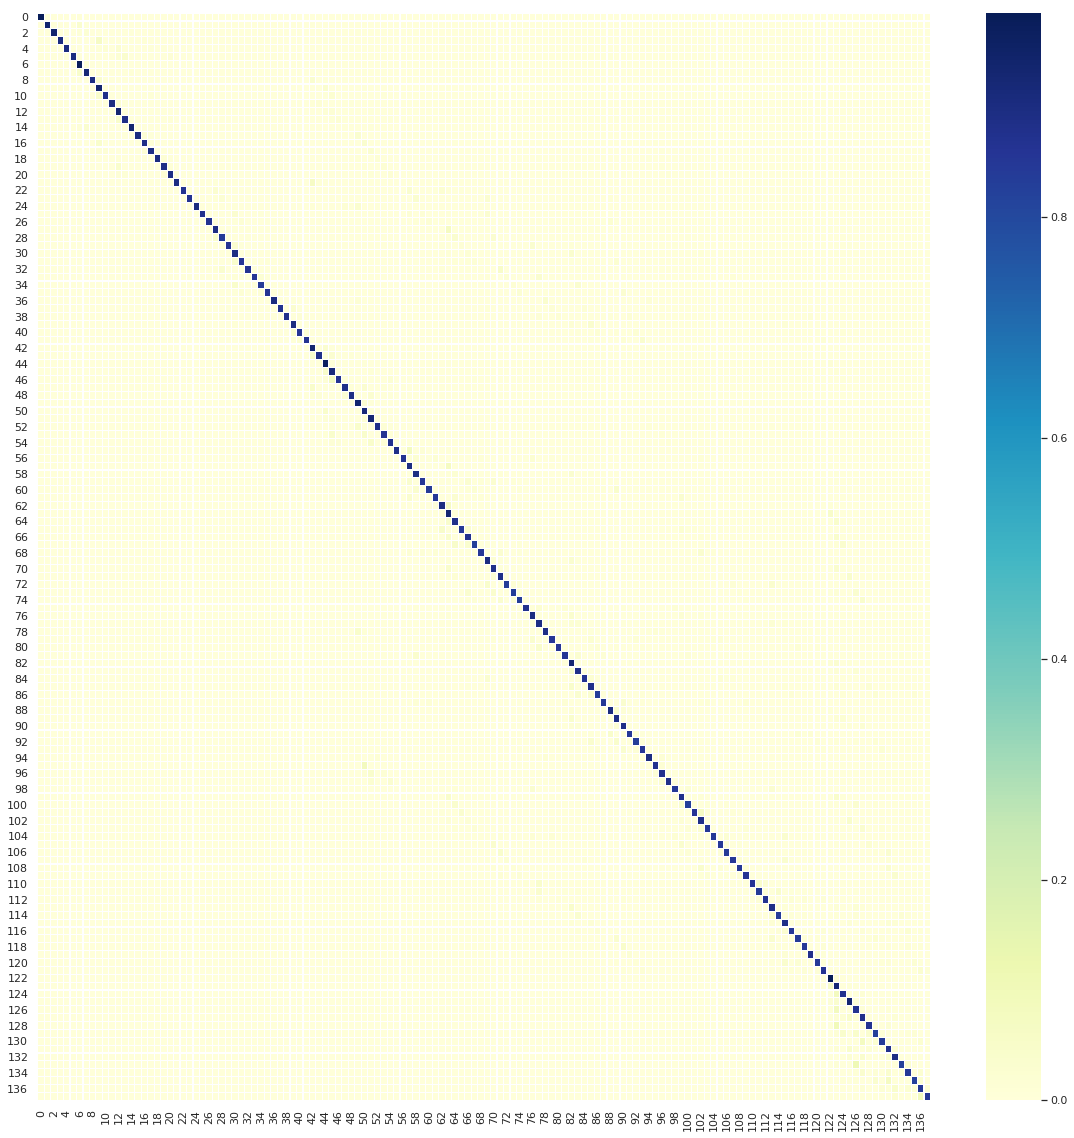

In [46]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(acc_mean_transition_matrix, cmap="YlGnBu", linewidths=.1);

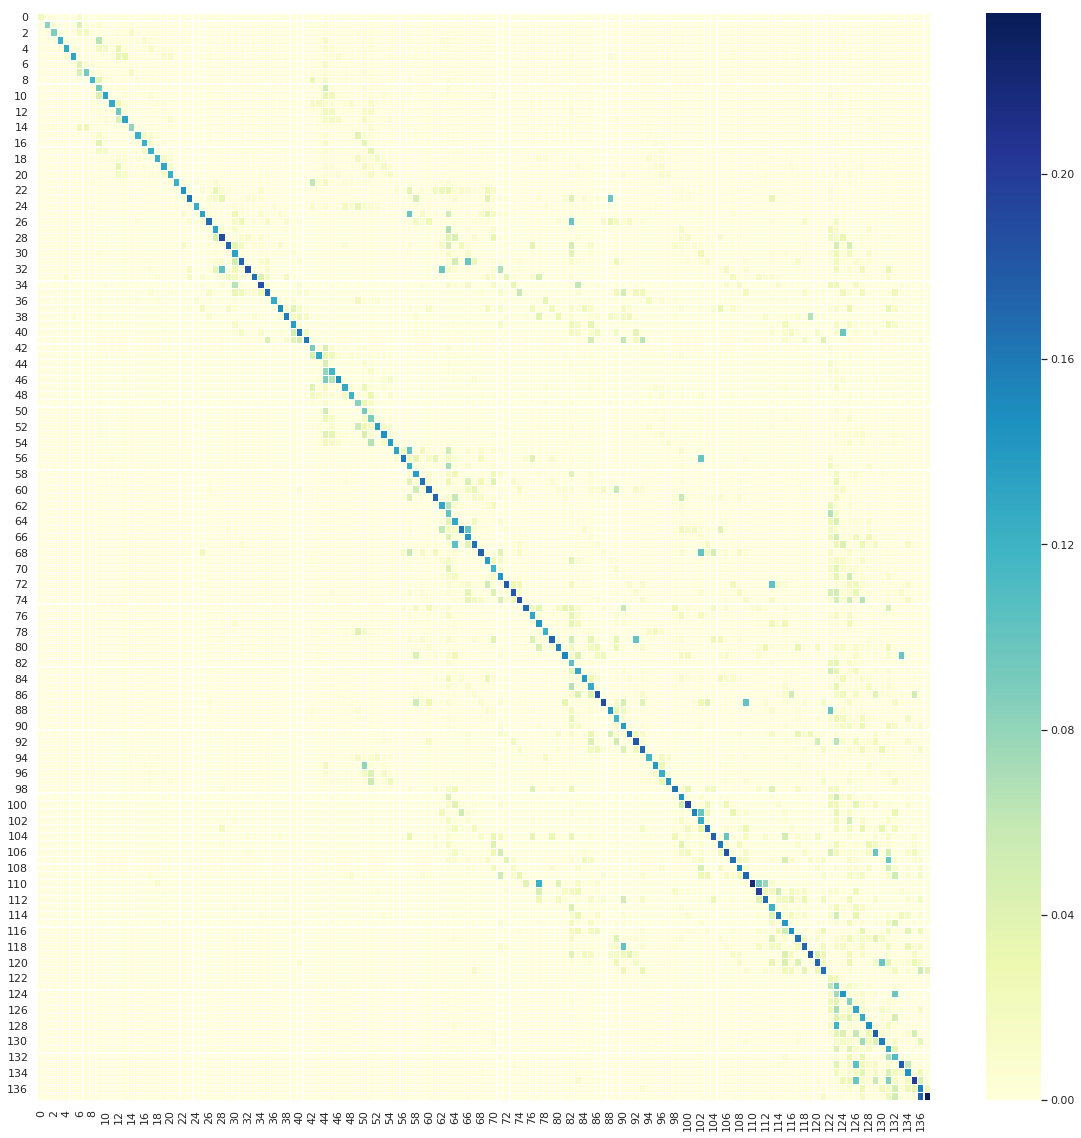

In [47]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(acc_std_transition_matrix, cmap="YlGnBu", linewidths=.1);

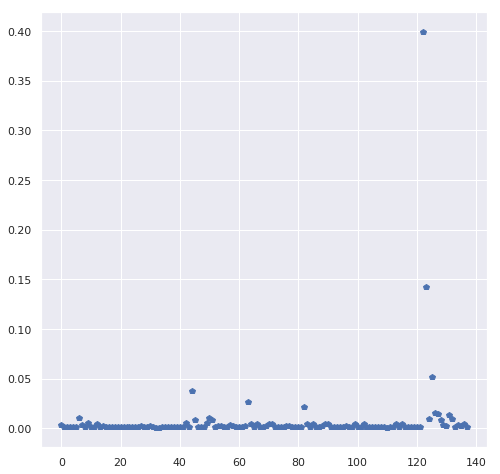

In [48]:
sns.set(rc={'figure.figsize': (8, 8)})
acc_st_dist = network_utils.get_stationary_distribution(acc_mean_transition_matrix)
plt.plot(acc_st_dist, 'p');

In [49]:
for index in np.where(acc_st_dist >= 0.06)[0]:
    print(triad_list[index])
    print('\n')

[[0 1 1]
 [1 0 1]
 [1 1 0]]


[[ 0  1  1]
 [ 1  0  1]
 [ 1 -1  0]]




In [50]:
for index in np.where(acc_st_dist >= np.mean(acc_st_dist))[0]:
    print(triad_list[index])
    print('\n')

[[0 0 0]
 [0 0 1]
 [0 1 0]]


[[0 0 1]
 [0 0 1]
 [1 1 0]]


[[ 0  0  1]
 [ 0  0  1]
 [ 1 -1  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1  1  0]]


[[ 0  0  1]
 [ 0  0 -1]
 [ 1 -1  0]]


[[0 0 1]
 [1 0 1]
 [1 1 0]]


[[ 0  0  1]
 [-1  0  1]
 [ 1  1  0]]


[[0 1 1]
 [1 0 1]
 [1 1 0]]


[[ 0  1  1]
 [ 1  0  1]
 [ 1 -1  0]]


[[ 0  1  1]
 [ 1  0  1]
 [-1 -1  0]]


[[ 0  1  1]
 [ 1  0 -1]
 [ 1 -1  0]]


[[ 0  1  1]
 [ 1  0 -1]
 [-1  1  0]]


[[ 0  1  1]
 [ 1  0 -1]
 [-1 -1  0]]


[[ 0  1  1]
 [-1  0  1]
 [-1  1  0]]


[[ 0  1 -1]
 [ 1  0 -1]
 [ 1 -1  0]]


[[ 0  1 -1]
 [ 1  0 -1]
 [-1 -1  0]]


